#<center>**H1B Visa Predictions**</center>

---


##<center> Name: Prerak Shah, Sai Sri Meghana Dharmapuri

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Preprocessing

In [0]:
import collections
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os
from sklearn import metrics
from sklearn.metrics import roc_curve, auc 
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
%matplotlib inline

# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)



# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes

def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    

# Plot an ROC. pred - the predictions, y - the expected output.
def plot_roc(pred,y):
    fpr, tpr, thresholds = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
data = pd.read_csv("/content/drive/My Drive/Colab Notebooks/H1B Case Status Prediction/h1b_kaggle.csv")

In [0]:
data.head()

,Unnamed: 0,CASE_STATUS,EMPLOYER_NAME,SOC_NAME,JOB_TITLE,FULL_TIME_POSITION,PREVAILING_WAGE,YEAR,WORKSITE,lon,lat
0,1,CERTIFIED-WITHDRAWN,UNIVERSITY OF MICHIGAN,BIOCHEMISTS AND BIOPHYSICISTS,POSTDOCTORAL RESEARCH FELLOW,N,36067.0,2016.0,"ANN ARBOR, MICHIGAN",-83.743038,42.280826
1,2,CERTIFIED-WITHDRAWN,"GOODMAN NETWORKS, INC.",CHIEF EXECUTIVES,CHIEF OPERATING OFFICER,Y,242674.0,2016.0,"PLANO, TEXAS",-96.698886,33.019843
2,3,CERTIFIED-WITHDRAWN,"PORTS AMERICA GROUP, INC.",CHIEF EXECUTIVES,CHIEF PROCESS OFFICER,Y,193066.0,2016.0,"JERSEY CITY, NEW JERSEY",-74.077642,40.728158
3,4,CERTIFIED-WITHDRAWN,"GATES CORPORATION, A WHOLLY-OWNED SUBSIDIARY O...",CHIEF EXECUTIVES,"REGIONAL PRESIDEN, AMERICAS",Y,220314.0,2016.0,"DENVER, COLORADO",-104.990251,39.739236
4,5,WITHDRAWN,PEABODY INVESTMENTS CORP.,CHIEF EXECUTIVES,PRESIDENT MONGOLIA AND INDIA,Y,157518.4,2016.0,"ST. LOUIS, MISSOURI",-90.199404,38.627003


In [0]:
# Replace unnamed column
data.rename(columns={'Unnamed: 0':'CASE_ID'}, inplace=True)

In [0]:
data.head()

,CASE_ID,CASE_STATUS,EMPLOYER_NAME,SOC_NAME,JOB_TITLE,FULL_TIME_POSITION,PREVAILING_WAGE,YEAR,WORKSITE,lon,lat
0,1,CERTIFIED-WITHDRAWN,UNIVERSITY OF MICHIGAN,BIOCHEMISTS AND BIOPHYSICISTS,POSTDOCTORAL RESEARCH FELLOW,N,36067.0,2016.0,"ANN ARBOR, MICHIGAN",-83.743038,42.280826
1,2,CERTIFIED-WITHDRAWN,"GOODMAN NETWORKS, INC.",CHIEF EXECUTIVES,CHIEF OPERATING OFFICER,Y,242674.0,2016.0,"PLANO, TEXAS",-96.698886,33.019843
2,3,CERTIFIED-WITHDRAWN,"PORTS AMERICA GROUP, INC.",CHIEF EXECUTIVES,CHIEF PROCESS OFFICER,Y,193066.0,2016.0,"JERSEY CITY, NEW JERSEY",-74.077642,40.728158
3,4,CERTIFIED-WITHDRAWN,"GATES CORPORATION, A WHOLLY-OWNED SUBSIDIARY O...",CHIEF EXECUTIVES,"REGIONAL PRESIDEN, AMERICAS",Y,220314.0,2016.0,"DENVER, COLORADO",-104.990251,39.739236
4,5,WITHDRAWN,PEABODY INVESTMENTS CORP.,CHIEF EXECUTIVES,PRESIDENT MONGOLIA AND INDIA,Y,157518.4,2016.0,"ST. LOUIS, MISSOURI",-90.199404,38.627003


In [0]:
data.isna().sum()

CASE_ID                    0
CASE_STATUS               13
EMPLOYER_NAME             59
SOC_NAME               17734
JOB_TITLE                 43
FULL_TIME_POSITION        15
PREVAILING_WAGE           85
YEAR                      13
WORKSITE                   0
lon                   107242
lat                   107242
dtype: int64

In [0]:
# thresh takes integer value which tells minimum amount of na values to drop.
data = data.dropna(thresh=2)

In [0]:
data.isna().sum()

CASE_ID                    0
CASE_STATUS               13
EMPLOYER_NAME             59
SOC_NAME               17734
JOB_TITLE                 43
FULL_TIME_POSITION        15
PREVAILING_WAGE           85
YEAR                      13
WORKSITE                   0
lon                   107242
lat                   107242
dtype: int64

In [0]:
# Drop Id that is of no use for prediction and columns with most null values
data = data.drop('CASE_ID', axis=1)
data = data.drop('lat', axis = 1)
data = data.drop('lon', axis = 1)

In [0]:
data.shape

(3002458, 8)

In [0]:
data.isna().sum()

CASE_STATUS              13
EMPLOYER_NAME            59
SOC_NAME              17734
JOB_TITLE                43
FULL_TIME_POSITION       15
PREVAILING_WAGE          85
YEAR                     13
WORKSITE                  0
dtype: int64

In [0]:
data.dtypes

CASE_STATUS            object
EMPLOYER_NAME          object
SOC_NAME               object
JOB_TITLE              object
FULL_TIME_POSITION     object
PREVAILING_WAGE       float64
YEAR                  float64
WORKSITE               object
dtype: object

In [0]:
data.describe()

,PREVAILING_WAGE,YEAR
count,3.002373e+06,3.002445e+06
mean,1.469984e+05,2.013855e+03
std,5.287609e+06,1.680612e+00
min,0.000000e+00,2.011000e+03
25%,5.437100e+04,2.012000e+03
50%,6.502100e+04,2.014000e+03
75%,8.143200e+04,2.015000e+03
max,6.997607e+09,2.016000e+03


# CASE_STATUS

In [0]:
data.isna().sum()

CASE_STATUS              13
EMPLOYER_NAME            59
SOC_NAME              17734
JOB_TITLE                43
FULL_TIME_POSITION       15
PREVAILING_WAGE          85
YEAR                     13
WORKSITE                  0
dtype: int64

In [0]:
# drop rows from Case_Status column with null value
data = data.dropna(subset=['CASE_STATUS'])

In [0]:
data.isna().sum()

CASE_STATUS               0
EMPLOYER_NAME            46
SOC_NAME              17721
JOB_TITLE                30
FULL_TIME_POSITION        2
PREVAILING_WAGE          72
YEAR                      0
WORKSITE                  0
dtype: int64

In [0]:
# Counts values for individual labels
print(data['CASE_STATUS'].value_counts())

CERTIFIED                                             2615623
CERTIFIED-WITHDRAWN                                    202659
DENIED                                                  94346
WITHDRAWN                                               89799
PENDING QUALITY AND COMPLIANCE REVIEW - UNASSIGNED         15
REJECTED                                                    2
INVALIDATED                                                 1
Name: CASE_STATUS, dtype: int64


In [0]:
# Drop rows with values of WITHDRAWN, PENDING QUALITY AND COMPLIANCE REVIEW - UNASSIGNED, CERTIFIED-WITHDRAWN as it is related to the user.
data = data.drop(data[data.CASE_STATUS == 'WITHDRAWN'].index)
data = data.drop(data[data.CASE_STATUS == 'PENDING QUALITY AND COMPLIANCE REVIEW - UNASSIGNED'].index)
data = data.drop(data[data.CASE_STATUS == 'CERTIFIED-WITHDRAWN'].index)

In [0]:
# Save REJECTED, INVALIDATED as DENIED as these status means that H1B status is denied.
import warnings
warnings.filterwarnings("ignore")
data.CASE_STATUS[data['CASE_STATUS']=='REJECTED'] = 'DENIED'
data.CASE_STATUS[data['CASE_STATUS']=='INVALIDATED'] = 'DENIED'

In [0]:
data.CASE_STATUS.value_counts()

CERTIFIED    2615623
DENIED         94349
Name: CASE_STATUS, dtype: int64

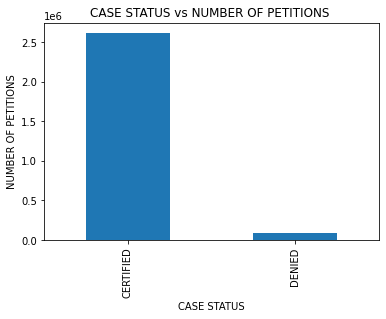

In [0]:
# Plot bar graph for CASE STATUS vs NUMBER OF PETITIONS
data.CASE_STATUS.value_counts().plot(kind='bar')
plt.title("CASE STATUS vs NUMBER OF PETITIONS ")
plt.xlabel('CASE STATUS')  
plt.ylabel('NUMBER OF PETITIONS')
plt.savefig('/content/drive/My Drive/Colab Notebooks/H1B Case Status Prediction/Case_Satus.png') 

# Data Analysis

In [0]:
data.YEAR.value_counts()

2016.0    578821
2015.0    558201
2014.0    467043
2013.0    395077
2012.0    373764
2011.0    337066
Name: YEAR, dtype: int64

In [0]:
data.YEAR.unique()

array([2016., 2015., 2014., 2013., 2012., 2011.])

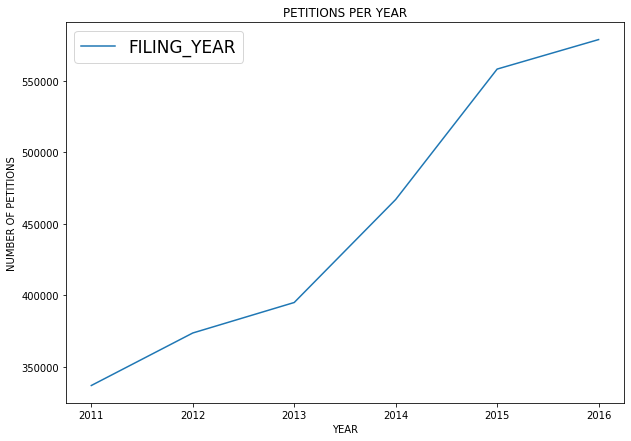

<Figure size 432x288 with 0 Axes>

In [0]:
# plot graph for petitons filed per year 
x = data['YEAR'].unique()  
y = data.YEAR.value_counts()
plt.figure(figsize=(10,7))
plt.xlabel('YEAR')
plt.ylabel('NUMBER OF PETITIONS')
plt.plot(x,y)
plt.title("PETITIONS PER YEAR")
plt.legend(['FILING_YEAR'], loc='upper left', prop={'size':17})
plt.show() 
plt.savefig('/content/drive/My Drive/Colab Notebooks/H1B Case Status Prediction/Petitions per year.png') 

In [0]:
group = data.groupby(['YEAR','CASE_STATUS'])['EMPLOYER_NAME'].count().unstack('CASE_STATUS')

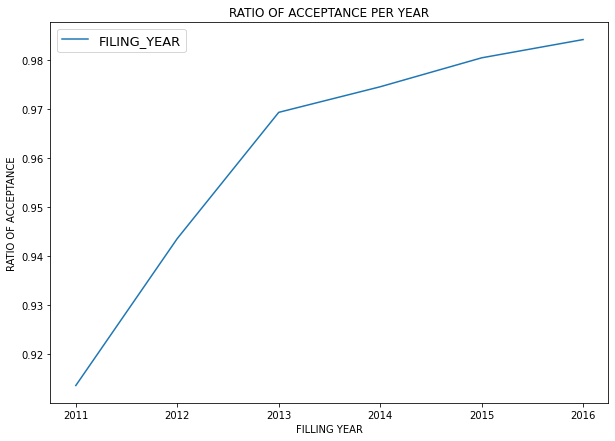

In [0]:
# Plot graph for Ratio of Acceptance per year
ratio = group['CERTIFIED']/(group['DENIED']+group['CERTIFIED'])
plt.figure(figsize=(10,7))
ratio.plot()
plt.legend(['FILING_YEAR'], loc='upper left', prop={'size':13})
plt.title("RATIO OF ACCEPTANCE PER YEAR")
plt.xlabel('FILLING YEAR')  
plt.ylabel('RATIO OF ACCEPTANCE')
plt.savefig('/content/drive/My Drive/Colab Notebooks/H1B Case Status Prediction/Acceptanceratio.png')

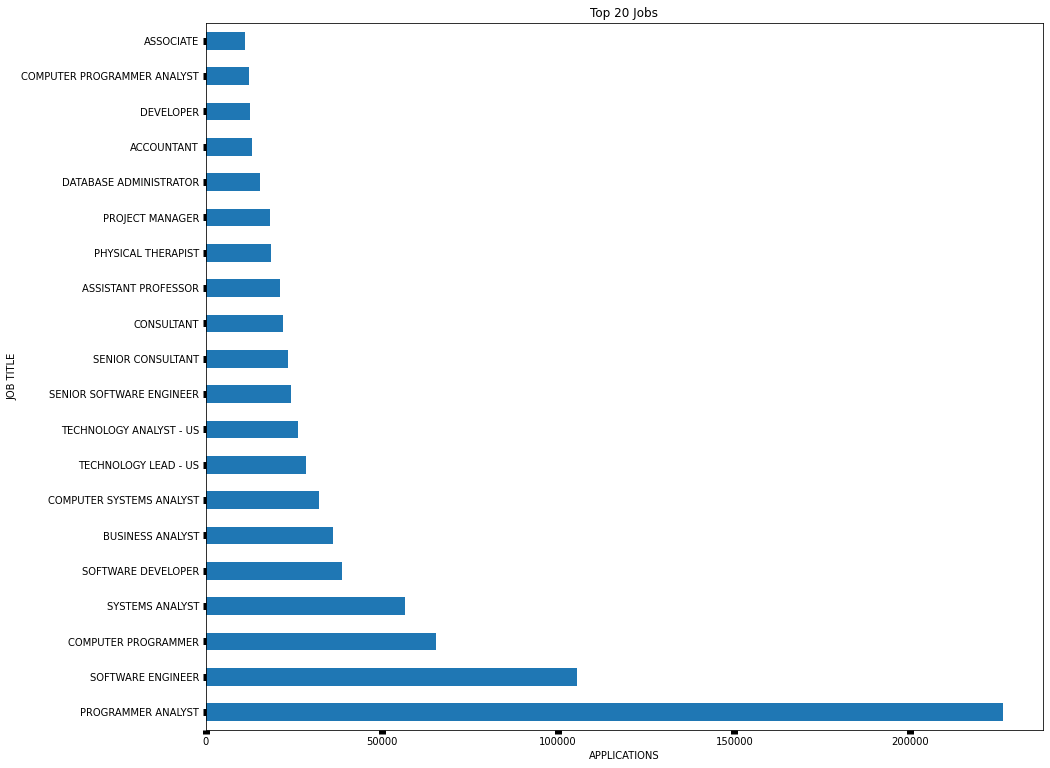

<Figure size 432x288 with 0 Axes>

In [0]:
# Plot graph for top 20 job title that applied for H1B visa
fig,ax = plt.subplots(figsize=(15,13))
ax.tick_params(labelsize='medium', width=7)
jobs = data['JOB_TITLE'].value_counts().sort_values(ascending=False).head(20).plot(kind='barh')
plt.title('Top 20 Jobs')
plt.xlabel('APPLICATIONS')  
plt.ylabel('JOB TITLE')
plt.show()
plt.savefig('/content/drive/My Drive/Colab Notebooks/H1B Case Status Prediction/top20jobs.png')

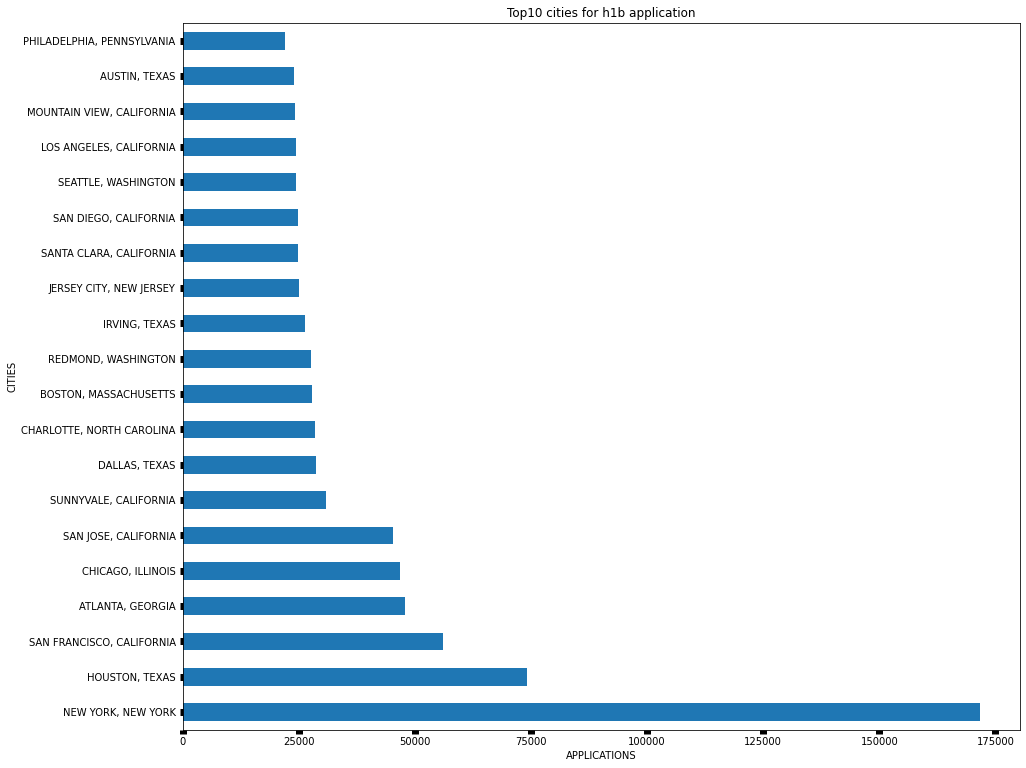

<Figure size 432x288 with 0 Axes>

In [0]:
# Plot graph for top 20 cities from where the Applications were filed
fig,ax = plt.subplots(figsize=(15,13))
ax.tick_params(labelsize='medium', width=7)
data['WORKSITE'].value_counts().head(20).plot(kind='barh')
plt.title('Top10 cities for h1b application')
plt.xlabel('APPLICATIONS')  
plt.ylabel('CITIES')
plt.show()
plt.savefig('/content/drive/My Drive/Colab Notebooks/H1B Case Status Prediction/top10cities.png')

In [0]:
data.isna().sum()

CASE_STATUS               0
EMPLOYER_NAME            18
SOC_NAME              15893
JOB_TITLE                10
FULL_TIME_POSITION        1
PREVAILING_WAGE          53
YEAR                      0
WORKSITE                  0
dtype: int64

In [0]:
# Replacing null values for object datatype by the mode of that column
data['EMPLOYER_NAME'] = data['EMPLOYER_NAME'].fillna(data['EMPLOYER_NAME'].mode()[0])
data['SOC_NAME'] = data['SOC_NAME'].fillna(data['SOC_NAME'].mode()[0])
data['JOB_TITLE'] = data['JOB_TITLE'].fillna(data['JOB_TITLE'].mode()[0])
data['FULL_TIME_POSITION'] = data['FULL_TIME_POSITION'].fillna(data['FULL_TIME_POSITION'].mode()[0])

In [0]:
# Replacing null values for PREVAILING_WAGE with the mean of the data as is of float datatype
data['PREVAILING_WAGE'] = data['PREVAILING_WAGE'].fillna(data.PREVAILING_WAGE.mean())

In [0]:
data.shape

(2709972, 8)

# PREVAILING_WAGE

In [0]:
# Print min, max, median and mode for the PREVAILING_WAGE column
print(data['PREVAILING_WAGE'].max())
print(data['PREVAILING_WAGE'].min())
print(data['PREVAILING_WAGE'].mode())
print(data['PREVAILING_WAGE'].median())

6997606720.0
0.0
0    60000.0
dtype: float64
65041.6


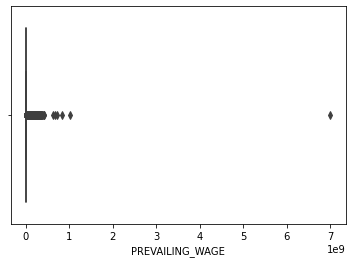

In [0]:
import seaborn as sns
sns.boxplot(x=data['PREVAILING_WAGE'])

In [0]:
data.shape

(2709972, 8)

In [0]:
# Taking the values for the 25th and 80th quantile for the column to overcome the outliers
q = data['PREVAILING_WAGE'].quantile(0.80)
print(q)
q1 = data['PREVAILING_WAGE'].quantile(0.25)
print(q1)

86445.0
54496.0


In [0]:
# Taking the data between the quantile ranges 
data = data[data['PREVAILING_WAGE']<q]
data = data[data['PREVAILING_WAGE']>q1]

In [0]:
data.shape

(1490057, 8)

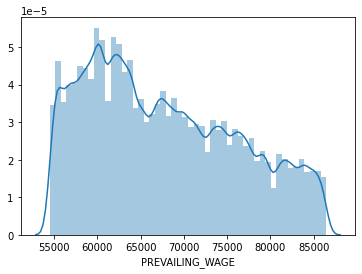

In [0]:
# Plotting Distplot to see the distrubution of the data
sns.distplot(data['PREVAILING_WAGE'])

In [0]:
# Adding new column
data['WAGE'] = np.nan
data.shape

(1490057, 9)

In [0]:
# Taking log Transformation
data['WAGE'] = np.log(data['PREVAILING_WAGE'])

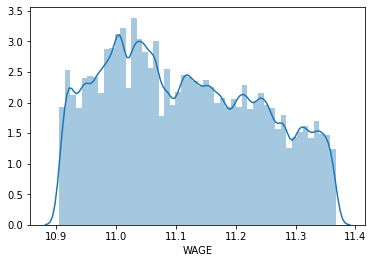

In [0]:
sns.distplot(data['WAGE'])

In [0]:
# Taking cube root Transformation for the logarithmic values of the column
data['WAGE'] = data.WAGE**(1/3)

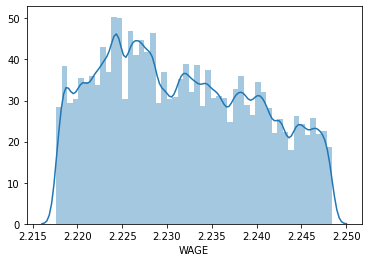

In [0]:
sns.distplot(data['WAGE'])

In [0]:
data['WAGE'].describe()

count    1.490057e+06
mean     2.231636e+00
std      8.431833e-03
min      2.217620e+00
25%      2.224527e+00
50%      2.230966e+00
75%      2.238525e+00
max      2.248461e+00
Name: WAGE, dtype: float64

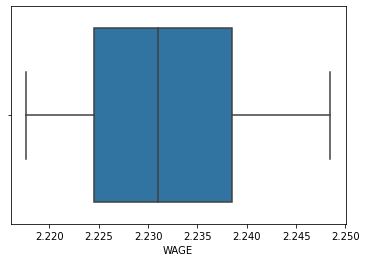

In [0]:
import seaborn as sns
sns.boxplot(x=data['WAGE'])

# Employer

In [0]:
# Adding new column
data['EMPLOYER'] = np.nan
data.shape

(1490057, 10)

In [0]:
# Converting the column values into lowercase
data['EMPLOYER_NAME'] = data['EMPLOYER_NAME'].str.lower()

In [0]:
data.EMPLOYER_NAME.head(30)

45     the chicago athenaeum: center for architecture...
61                                     sensorhound, inc.
74                                  university at albany
93                          california masterplant, inc.
96                            aruze gaming america, inc.
110                        tms plumbing and heating corp
112                                        benyoucef llc
137                        tms plumbing and heating corp
139                                 light & star usa inc
179                     medicus management services, llc
188                        sente advisory services, inc.
195                                    sensorhound, inc.
198                                        snaprays, llc
234                                        snaprays, llc
235                                        snaprays, llc
237                                        snaprays, llc
238                                        snaprays, llc
239                            

In [0]:
# As there were too many values, the data is divided into 4 classes
warnings.filterwarnings("ignore")
data.EMPLOYER[data['EMPLOYER_NAME'].str.contains('university')] = 'university'
data.EMPLOYER[data['EMPLOYER_NAME'].str.contains('llc')] = 'limited liability company'
data.EMPLOYER[data['EMPLOYER_NAME'].str.contains('inc','corp')] = 'corporation'
data['EMPLOYER']= data.EMPLOYER.replace(np.nan, 'non university', regex=True)

In [0]:
data.EMPLOYER.unique()

array(['non university', 'corporation', 'university',
       'limited liability company'], dtype=object)

In [0]:
data.EMPLOYER.value_counts()

corporation                  734447
non university               553256
limited liability company    179008
university                    23346
Name: EMPLOYER, dtype: int64

# SOC

In [0]:
data.SOC_NAME.unique()

array(['CHIEF EXECUTIVES', 'GENERAL AND OPERATIONS MANAGERS',
       'GENERAL AND OPERATIONS MANAGER', ...,
       'Entertainment Attendants and Related Workers, All ',
       'Electrical and Electronics Repairers, Powerhouse, ',
       'Earth Drillers, Except Oil and Gas'], dtype=object)

In [0]:
# Convert columns values in lowercase
data['SOC_NAME'] = data['SOC_NAME'].str.lower()

1331753
1490057
Ratio of data covered within top 35 SOC names: 0.8937597689215916


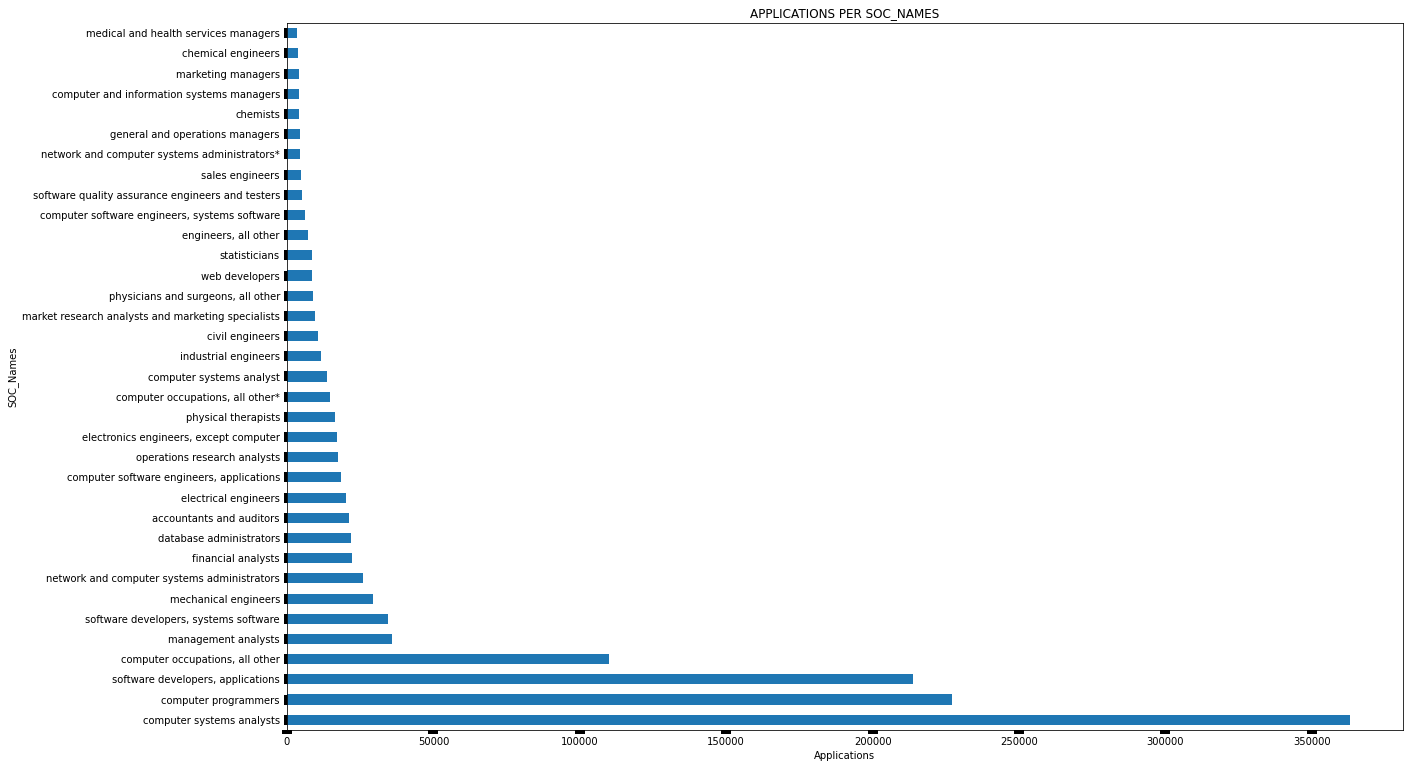

In [0]:
v1 = data.SOC_NAME.value_counts().head(35).sum()
v2 = data.SOC_NAME.value_counts().sum()
print(v1)
print(v2)
print("Ratio of data covered within top 35 SOC names:",v1/v2)
fig,ax = plt.subplots(figsize=(20,13))
ax.tick_params(labelsize='medium', width=10)
plt.title("APPLICATIONS PER SOC_NAMES")
plt.xlabel('Applications')  
plt.ylabel('SOC_Names')
soc = data.SOC_NAME.value_counts().head(35).plot(kind='barh')
plt.savefig('/content/drive/My Drive/Colab Notebooks/H1B Case Status Prediction/Top 35 SOC values.png') 

In [0]:
# Adding new column dividing the values into different classes according to the top 35 SOC names
warnings.filterwarnings("ignore")
data['OCCUPATION'] = np.nan
data.OCCUPATION[data['SOC_NAME'].str.contains('computer','database')] = 'Computer Occupation'
data.OCCUPATION[data['SOC_NAME'].str.contains('software','developers')] = 'Computer Occupation'
data.OCCUPATION[data['SOC_NAME'].str.contains('math','statistic')] = 'Mathematical Occupation'
data.OCCUPATION[data['SOC_NAME'].str.contains('statisticians','logisticians')] = 'Mathematical Occupation'
data.OCCUPATION[data['SOC_NAME'].str.contains('principal','linguist')] = 'Education Occupation'
data.OCCUPATION[data['SOC_NAME'].str.contains('professor','Teach')] = 'Education Occupation'
data.OCCUPATION[data['SOC_NAME'].str.contains('medical','doctor')] = 'Medical Occupation'
data.OCCUPATION[data['SOC_NAME'].str.contains('physician','dentist')] = 'Medical Occupation'
data.OCCUPATION[data['SOC_NAME'].str.contains('health','Physical Therapists')] = 'Medical Occupation'
data.OCCUPATION[data['SOC_NAME'].str.contains('surgeon','nurse')] = 'Medical Occupation'
data.OCCUPATION[data['SOC_NAME'].str.contains('chemists','physicist')] = 'Advance Sciences'
data.OCCUPATION[data['SOC_NAME'].str.contains('biochemists','biophysicists')] = 'Advance Sciences'
data.OCCUPATION[data['SOC_NAME'].str.contains('biology','scientists')] = 'Advance Sciences'
data.OCCUPATION[data['SOC_NAME'].str.contains('research')] = 'Advance Sciences'
data.OCCUPATION[data['SOC_NAME'].str.contains('biologi','clinical research')] = 'Advance Sciences'
data.OCCUPATION[data['SOC_NAME'].str.contains('public relation','managers')] = 'Management Occupation'
data.OCCUPATION[data['SOC_NAME'].str.contains('management','operation')] = 'Management Occupation'
data.OCCUPATION[data['SOC_NAME'].str.contains('chief','plan')] = 'Management Occupation'
data.OCCUPATION[data['SOC_NAME'].str.contains('executive')] = 'Management Occupation'
data.OCCUPATION[data['SOC_NAME'].str.contains('advertis','marketing')] = 'Bussiness and Marketing Occupation'
data.OCCUPATION[data['SOC_NAME'].str.contains('promotion','market research')] = 'Bussiness and Marketing Occupation'
data.OCCUPATION[data['SOC_NAME'].str.contains('business','business analyst')] = 'Bussiness and Marketing Occupation'
data.OCCUPATION[data['SOC_NAME'].str.contains('business systems analyst')] = 'Bussiness and Marketing Occupation'
data.OCCUPATION[data['SOC_NAME'].str.contains('accountants','finance')] = 'Financial Occupation'
data.OCCUPATION[data['SOC_NAME'].str.contains('financial')] = 'Financial Occupation'
data.OCCUPATION[data['SOC_NAME'].str.contains('engineers','architect')] = 'Engineering'
data.OCCUPATION[data['SOC_NAME'].str.contains('technician')] = 'Engineering'
data.OCCUPATION[data['SOC_NAME'].str.contains('information')] = 'Engineering'
data['OCCUPATION']= data.OCCUPATION.replace(np.nan, 'Others', regex=True)

In [0]:
data.OCCUPATION.unique()

array(['Management Occupation', 'Others',
       'Bussiness and Marketing Occupation', 'Engineering',
       'Financial Occupation', 'Medical Occupation', 'Advance Sciences',
       'Computer Occupation', 'Mathematical Occupation'], dtype=object)

In [0]:
data.OCCUPATION.value_counts()

Computer Occupation                   1016907
Engineering                            164978
Others                                 144245
Financial Occupation                    50034
Management Occupation                   38335
Advance Sciences                        38280
Medical Occupation                      22094
Mathematical Occupation                  9952
Bussiness and Marketing Occupation       5232
Name: OCCUPATION, dtype: int64

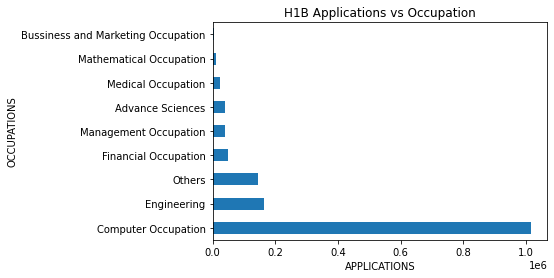

In [0]:
data.OCCUPATION.value_counts().plot(kind='barh')
plt.title("H1B Applications vs Occupation")
plt.xlabel("APPLICATIONS")
plt.ylabel("OCCUPATIONS")
plt.savefig('/content/drive/My Drive/Colab Notebooks/H1B Case Status Prediction/Applications per Occupation.png') 

# WORKSITE

In [0]:
# SPlit the states from the Worksite
data.WORKSITE.str.split(',').str[-1]

45            ILLINOIS
61             INDIANA
74            NEW YORK
93          CALIFORNIA
96              NEVADA
              ...     
3002348     CALIFORNIA
3002357           IOWA
3002360        GEORGIA
3002389       MICHIGAN
3002392       NEW YORK
Name: WORKSITE, Length: 1490057, dtype: object

In [0]:
# Adding the splitted states in the new column 'STATE'
data['STATE'] = data.WORKSITE.str.split(',').str[-1]

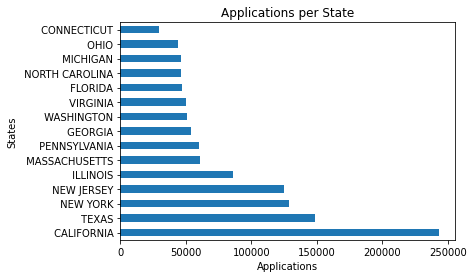

In [0]:
data.STATE.value_counts().head(15).plot(kind='barh')
plt.title("Applications per State")
plt.xlabel("Applications")
plt.ylabel("States")
plt.savefig('/content/drive/My Drive/Colab Notebooks/H1B Case Status Prediction/Applications per State.png') 

# FULL_TIME POSITION

In [0]:
data.FULL_TIME_POSITION.unique()

array(['N', 'Y'], dtype=object)

# JOB_TITLE

In [0]:
data.JOB_TITLE.value_counts().head(30)

PROGRAMMER ANALYST                  145629
SOFTWARE ENGINEER                    64079
COMPUTER PROGRAMMER                  44942
SYSTEMS ANALYST                      43684
SOFTWARE DEVELOPER                   28481
TECHNOLOGY LEAD - US                 26922
COMPUTER SYSTEMS ANALYST             24929
BUSINESS ANALYST                     24678
TECHNOLOGY ANALYST - US              19280
SENIOR CONSULTANT                    17839
CONSULTANT                           16708
PHYSICAL THERAPIST                   14980
PROJECT MANAGER                      11507
DEVELOPER                            10903
DATABASE ADMINISTRATOR               10246
LEAD ENGINEER                         9374
SENIOR SOFTWARE ENGINEER              8722
COMPUTER PROGRAMMER ANALYST           8337
ASSISTANT PROFESSOR                   7409
ANALYST                               7390
CONSULTANT - US                       7079
BUSINESS SYSTEMS ANALYST              6816
COMPUTER SYSTEMS ENGINEER             6432
COMPUTER PR

In [0]:
# Factorizing the column as there were many unique values
data['JOB_TITLE'], uniques = data['JOB_TITLE'].factorize()

In [0]:
data['JOB_TITLE']

45             0
61             1
74             2
93             3
96             4
           ...  
3002348     2169
3002357     8378
3002360    21862
3002389    11140
3002392    28073
Name: JOB_TITLE, Length: 1490057, dtype: int64

# Final Preprocessed Data

In [0]:
data.columns

Index(['CASE_STATUS', 'EMPLOYER_NAME', 'SOC_NAME', 'JOB_TITLE',
       'FULL_TIME_POSITION', 'PREVAILING_WAGE', 'YEAR', 'WORKSITE', 'WAGE',
       'EMPLOYER', 'OCCUPATION', 'STATE'],
      dtype='object')

In [0]:
# Dropping the duplicate columns
data = data.drop('EMPLOYER_NAME', axis = 1)
data = data.drop('SOC_NAME', axis = 1)
data = data.drop('WORKSITE', axis = 1)
data = data.drop('PREVAILING_WAGE', axis = 1)

In [0]:
# Mapping the target class to 1 and 0
class_mapping = {'CERTIFIED':1, 'DENIED':0}
data["CASE_STATUS"] = data["CASE_STATUS"].map(class_mapping)

In [0]:
data.head()

,CASE_STATUS,JOB_TITLE,FULL_TIME_POSITION,YEAR,WAGE,EMPLOYER,OCCUPATION,STATE
45,1,0,N,2016.0,2.217954,non university,Management Occupation,ILLINOIS
61,1,1,Y,2016.0,2.240592,corporation,Management Occupation,INDIANA
74,1,2,Y,2016.0,2.239317,university,Management Occupation,NEW YORK
93,1,3,Y,2016.0,2.247388,corporation,Management Occupation,CALIFORNIA
96,1,4,Y,2016.0,2.245388,corporation,Management Occupation,NEVADA


In [0]:
data.dtypes

CASE_STATUS             int64
JOB_TITLE               int64
FULL_TIME_POSITION     object
YEAR                  float64
WAGE                  float64
EMPLOYER               object
OCCUPATION             object
STATE                  object
dtype: object

# Encoding

In [0]:
# Applying one-hot encoding
encode_text_dummy(data,'FULL_TIME_POSITION')
encode_text_dummy(data,'YEAR')
encode_text_dummy(data,'EMPLOYER')
encode_text_dummy(data,'OCCUPATION')
encode_text_dummy(data,'STATE')

In [0]:
data.head()

,CASE_STATUS,JOB_TITLE,WAGE,FULL_TIME_POSITION-N,FULL_TIME_POSITION-Y,YEAR-2011.0,YEAR-2012.0,YEAR-2013.0,YEAR-2014.0,YEAR-2015.0,YEAR-2016.0,EMPLOYER-corporation,EMPLOYER-limited liability company,EMPLOYER-non university,EMPLOYER-university,OCCUPATION-Advance Sciences,OCCUPATION-Bussiness and Marketing Occupation,OCCUPATION-Computer Occupation,OCCUPATION-Engineering,OCCUPATION-Financial Occupation,OCCUPATION-Management Occupation,OCCUPATION-Mathematical Occupation,OCCUPATION-Medical Occupation,OCCUPATION-Others,STATE- ALABAMA,STATE- ALASKA,STATE- ARIZONA,STATE- ARKANSAS,STATE- CALIFORNIA,STATE- COLORADO,STATE- CONNECTICUT,STATE- DELAWARE,STATE- DISTRICT OF COLUMBIA,STATE- FLORIDA,STATE- GEORGIA,STATE- HAWAII,STATE- IDAHO,STATE- ILLINOIS,STATE- INDIANA,STATE- IOWA,STATE- KANSAS,STATE- KENTUCKY,STATE- LOUISIANA,STATE- MAINE,STATE- MARYLAND,STATE- MASSACHUSETTS,STATE- MICHIGAN,STATE- MINNESOTA,STATE- MISSISSIPPI,STATE- MISSOURI,STATE- MONTANA,STATE- NA,STATE- NEBRASKA,STATE- NEVADA,STATE- NEW HAMPSHIRE,STATE- NEW JERSEY,STATE- NEW MEXICO,STATE- NEW YORK,STATE- NORTH CAROLINA,STATE- NORTH DAKOTA,STATE- OHIO,STATE- OKLAHOMA,STATE- OREGON,STATE- PENNSYLVANIA,STATE- PUERTO RICO,STATE- RHODE ISLAND,STATE- SOUTH CAROLINA,STATE- SOUTH DAKOTA,STATE- TENNESSEE,STATE- TEXAS,STATE- UTAH,STATE- VERMONT,STATE- VIRGINIA,STATE- WASHINGTON,STATE- WEST VIRGINIA,STATE- WISCONSIN,STATE- WYOMING
45,1,0,2.217954,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
61,1,1,2.240592,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
74,1,2,2.239317,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
93,1,3,2.247388,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
96,1,4,2.245388,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
data.shape

(1490057, 77)

# Splitting in X and Y

In [0]:
x = data.drop('CASE_STATUS', axis=1)
y = data.CASE_STATUS

In [0]:
y.value_counts()

1    1451801
0      38256
Name: CASE_STATUS, dtype: int64

In [0]:
# Applying StandardScalar preprocessing on the x data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x = sc.fit_transform(x)
x

array([[-0.66405447, -1.62270003,  2.35185913, ..., -0.02227555,
        -0.10892274, -0.01105251],
       [-0.66401764,  1.06210778, -0.42519553, ..., -0.02227555,
        -0.10892274, -0.01105251],
       [-0.66398082,  0.91088923, -0.42519553, ..., -0.02227555,
        -0.10892274, -0.01105251],
       ...,
       [ 0.14102541,  1.30971286, -0.42519553, ..., -0.02227555,
        -0.10892274, -0.01105251],
       [-0.25381799, -1.56787247, -0.42519553, ..., -0.02227555,
        -0.10892274, -0.01105251],
       [ 0.36974881,  0.26315714, -0.42519553, ..., -0.02227555,
        -0.10892274, -0.01105251]])

# DownSampling with Near-miss

In [0]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

print(Counter(y))

Counter({1: 1451801, 0: 38256})


In [0]:
# Applying NearMiss downsampling technique for imbalanced data
from imblearn.under_sampling import NearMiss 
nr = NearMiss() 
  
x, y = nr.fit_sample(x, y) 

In [0]:
Counter(y)

Counter({0: 38256, 1: 38256})

#TRAIN-TEST SPLIT

In [0]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.20,random_state=0)

In [0]:
cols = data.drop(columns='CASE_STATUS').columns.tolist()

#Logistic Regression

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

lr=LogisticRegression()
lr.fit(x_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
# Accuracy
y_pred = lr.predict(x_test)
print('Accuracy of logistic regression classifier on test set:',lr.score(x_test, y_test))

Accuracy of logistic regression classifier on test set: 0.8576096190289486


[[6142 1425]
 [ 754 6982]]


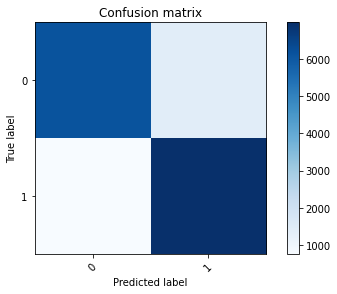

In [0]:
# Print and plot confusion matrix   
cm = confusion_matrix(y_test, y_pred)
print(cm)
plot_confusion_matrix(cm,['0','1'])

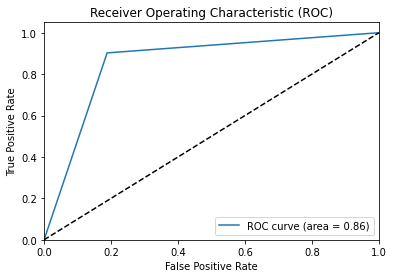

In [0]:
# Plot roc curve
plot_roc(y_pred,y_test)

In [0]:
# Print Classification Report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.89      0.81      0.85      7567
           1       0.83      0.90      0.87      7736

    accuracy                           0.86     15303
   macro avg       0.86      0.86      0.86     15303
weighted avg       0.86      0.86      0.86     15303



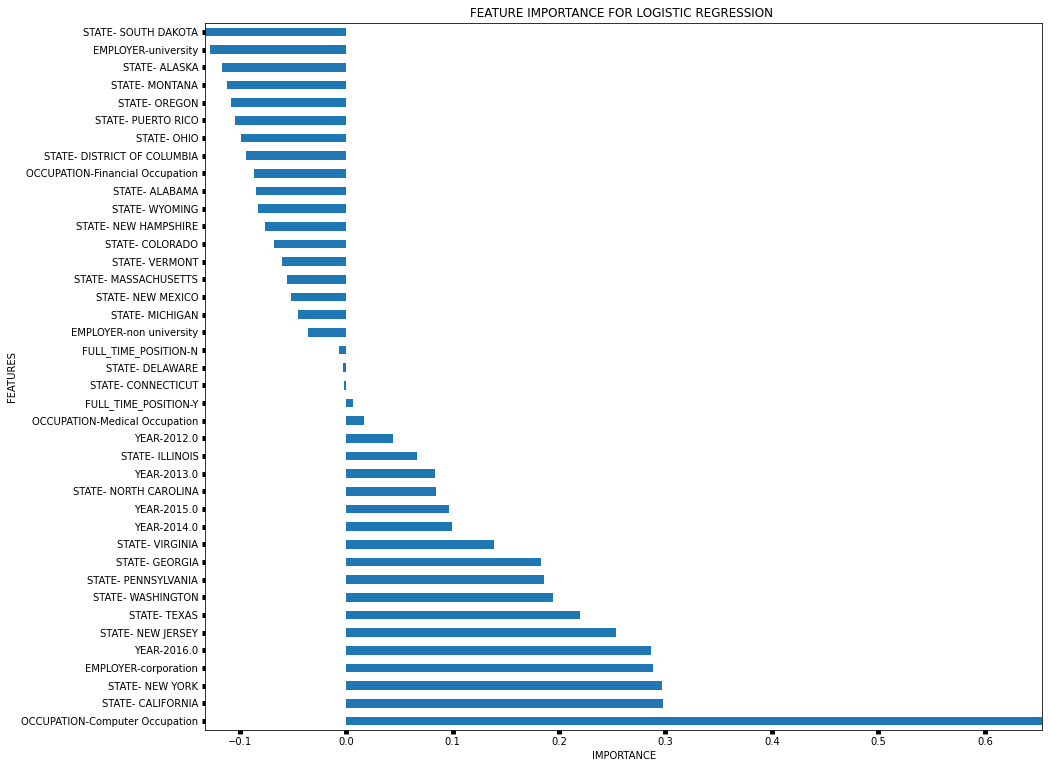

<Figure size 432x288 with 0 Axes>

In [0]:
# Plotting Top- 40 Feature Importances
fig,ax = plt.subplots(figsize=(15,13))
ax.tick_params(labelsize='medium', width=5)
importances = pd.Series(lr.coef_[0], index=cols)
importances.nlargest(40).plot(kind='barh')
lr40 = pd.Series(lr.coef_[0], index=cols).nlargest(40)
plt.title("FEATURE IMPORTANCE FOR LOGISTIC REGRESSION ")
plt.xlabel('IMPORTANCE')
plt.ylabel('FEATURES')
ax.margins(0, None)
plt.show()
plt.savefig('/content/drive/My Drive/Colab Notebooks/H1B Case Status Prediction/Logistic Regression Feature Importance') 

In [0]:
lr40

OCCUPATION-Computer Occupation     0.653887
STATE- CALIFORNIA                  0.297505
STATE- NEW YORK                    0.296432
EMPLOYER-corporation               0.288006
YEAR-2016.0                        0.286044
STATE- NEW JERSEY                  0.253098
STATE- TEXAS                       0.219291
STATE- WASHINGTON                  0.194825
STATE- PENNSYLVANIA                0.185904
STATE- GEORGIA                     0.183121
STATE- VIRGINIA                    0.138599
YEAR-2014.0                        0.099940
YEAR-2015.0                        0.097008
STATE- NORTH CAROLINA              0.084685
YEAR-2013.0                        0.083763
STATE- ILLINOIS                    0.066779
YEAR-2012.0                        0.044223
OCCUPATION-Medical Occupation      0.016964
FULL_TIME_POSITION-Y               0.006562
STATE- CONNECTICUT                -0.002189
STATE- DELAWARE                   -0.003085
FULL_TIME_POSITION-N              -0.006562
EMPLOYER-non university         

# Logistic Regression with L1(Lasso) penalty

In [0]:
C = [10, 1, .1, .001]

for c in C:
    clf = LogisticRegression(penalty='l1', C=c, solver='liblinear')
    clf.fit(x_train, y_train)
    print('C:', c)
    print('Coefficient of each feature:', clf.coef_)
    print('Training accuracy:', clf.score(x_train, y_train))
    print('Test accuracy:', clf.score(x_test, y_test))
    print('')

C: 10
Coefficient of each feature: [[-1.61003689 -0.47369808  0.01298899  0.0262064  -0.80243566  0.01213829
   0.0505285   0.06400883  0.05786968  0.24670224  0.4489743  -0.23608724
   0.11995232 -0.08774252 -0.17836116 -0.43895813  1.19340047  0.19081327
   0.12198107 -0.09455623 -0.07925637  0.15699975  0.03435515 -0.11161901
  -0.12146994 -0.38512019 -0.47211425  0.08920081 -0.12711958 -0.08102334
  -0.05266476 -0.14011781 -0.29093932  0.07763786 -0.24526527 -0.29213978
  -0.06425868 -0.18783001 -0.27194962 -0.26502103 -0.2000073  -0.39407776
  -0.25213229 -0.32140703 -0.16652722 -0.14329984 -0.22928368 -0.19385403
  -0.21713286 -0.11485045 -0.17250755 -0.4276221  -0.19515637 -0.10951316
   0.09719885 -0.07115502  0.13799005 -0.01330586 -0.17213875 -0.19402459
  -0.37085239 -0.1589211   0.07515611 -0.10139768 -0.5523906  -0.27303365
  -0.13327749 -0.20192633  0.0503999  -0.17320604 -0.0735901   0.03673028
   0.09271443 -0.17375616 -0.20356676 -0.08590749]]
Training accuracy: 0.8521

[[5648 1919]
 [ 592 7144]]


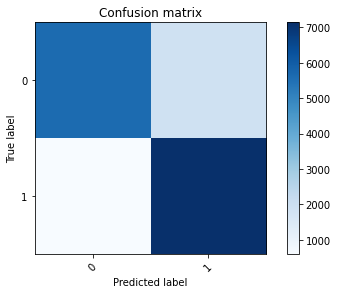

In [0]:
# Print and plot confusion matrix   
cm = confusion_matrix(y_test, clf.predict(x_test))
print(cm)
plot_confusion_matrix(cm,['0','1'])

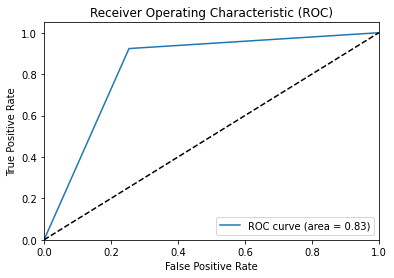

In [0]:
# Plot roc curve
plot_roc(clf.predict(x_test),y_test)

In [0]:
# Print Classification Report
print(classification_report(y_test,clf.predict(x_test)))

              precision    recall  f1-score   support

           0       0.91      0.75      0.82      7567
           1       0.79      0.92      0.85      7736

    accuracy                           0.84     15303
   macro avg       0.85      0.83      0.83     15303
weighted avg       0.85      0.84      0.83     15303



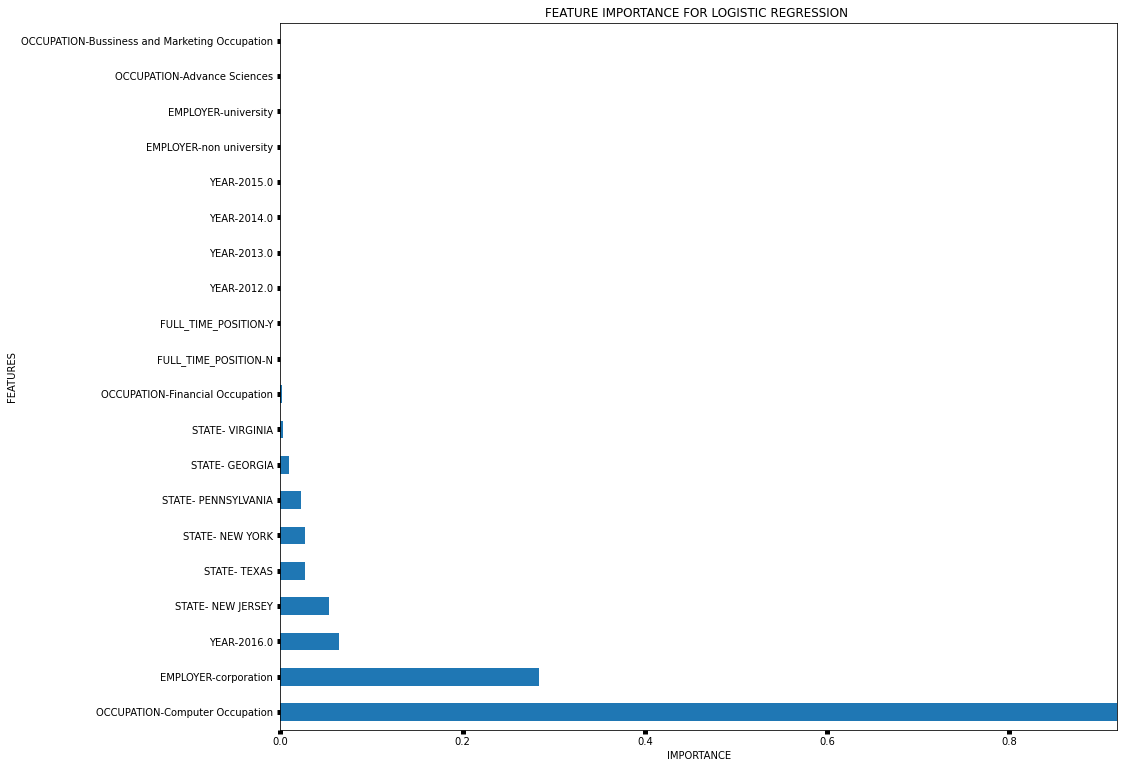

<Figure size 432x288 with 0 Axes>

In [0]:
# Plotting 20 Important features for Logistic Regression with penalty L1 
fig,ax = plt.subplots(figsize=(15,13))
ax.tick_params(labelsize='medium', width=5)
importances = pd.Series(clf.coef_[0], index=cols)
importances.nlargest(20).plot(kind='barh')
clf40 = pd.Series(clf.coef_[0], index=cols).nlargest(20)
plt.title("FEATURE IMPORTANCE FOR LOGISTIC REGRESSION ")
plt.xlabel('IMPORTANCE')
plt.ylabel('FEATURES')
ax.margins(0, None)
plt.show()
plt.savefig('/content/drive/My Drive/Colab Notebooks/H1B Case Status Prediction/Logistic Regression(L1) Feature Importance') 

In [0]:
clf40

OCCUPATION-Computer Occupation                   0.918695
EMPLOYER-corporation                             0.284077
YEAR-2016.0                                      0.064604
STATE- NEW JERSEY                                0.052985
STATE- TEXAS                                     0.027570
STATE- NEW YORK                                  0.026680
STATE- PENNSYLVANIA                              0.023094
STATE- GEORGIA                                   0.009516
STATE- VIRGINIA                                  0.002585
OCCUPATION-Financial Occupation                  0.002014
FULL_TIME_POSITION-N                             0.000000
FULL_TIME_POSITION-Y                             0.000000
YEAR-2012.0                                      0.000000
YEAR-2013.0                                      0.000000
YEAR-2014.0                                      0.000000
YEAR-2015.0                                      0.000000
EMPLOYER-non university                          0.000000
EMPLOYER-unive

# NAIVE BAYES

In [0]:
from sklearn.naive_bayes import BernoulliNB
bnb = BernoulliNB(binarize=0.0)
y_pred = bnb.fit(x_train, y_train)
y_pred = bnb.predict(x_test)

In [0]:
# Accuracy
from sklearn import metrics 
print("Bernoulli Naive Bayes model accuracy on test set:", metrics.accuracy_score(y_test, y_pred))

Bernoulli Naive Bayes model accuracy on test set: 0.8461086061556558


[[6026 1541]
 [ 814 6922]]


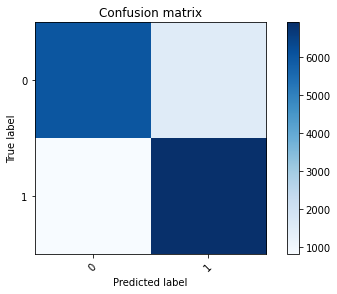

In [0]:
cm = confusion_matrix(y_test, y_pred)
print(cm)
plot_confusion_matrix(cm,['0','1'])

In [0]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.88      0.80      0.84      7567
           1       0.82      0.89      0.85      7736

    accuracy                           0.85     15303
   macro avg       0.85      0.85      0.85     15303
weighted avg       0.85      0.85      0.85     15303



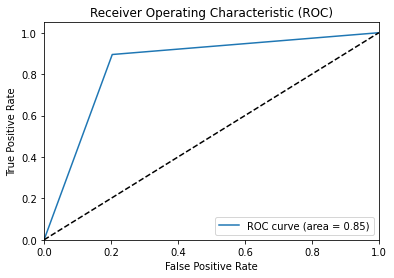

In [0]:
plot_roc(y_pred,y_test)

# RANDOM-FOREST

In [0]:
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
forest = RandomForestClassifier()

#Train the model using the training sets y_pred=clf.predict(X_test)
forest.fit(x_train,y_train)

y_pred=forest.predict(x_test)

In [0]:
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy of Random forest on test set:",metrics.accuracy_score(y_test, y_pred))

Accuracy of Random forest on test set: 0.9605959615761616


[[7092  475]
 [ 128 7608]]


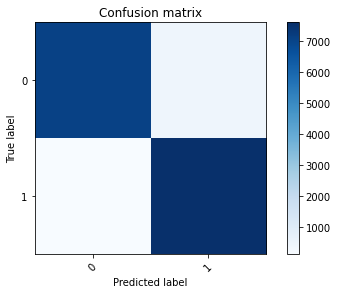

In [0]:
cm = confusion_matrix(y_test, y_pred)
print(cm)
plot_confusion_matrix(cm,['0','1'])

In [0]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.98      0.94      0.96      7567
           1       0.94      0.98      0.96      7736

    accuracy                           0.96     15303
   macro avg       0.96      0.96      0.96     15303
weighted avg       0.96      0.96      0.96     15303



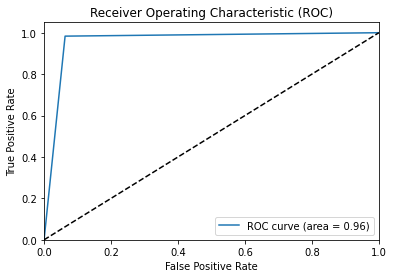

In [0]:
plot_roc(y_pred,y_test)

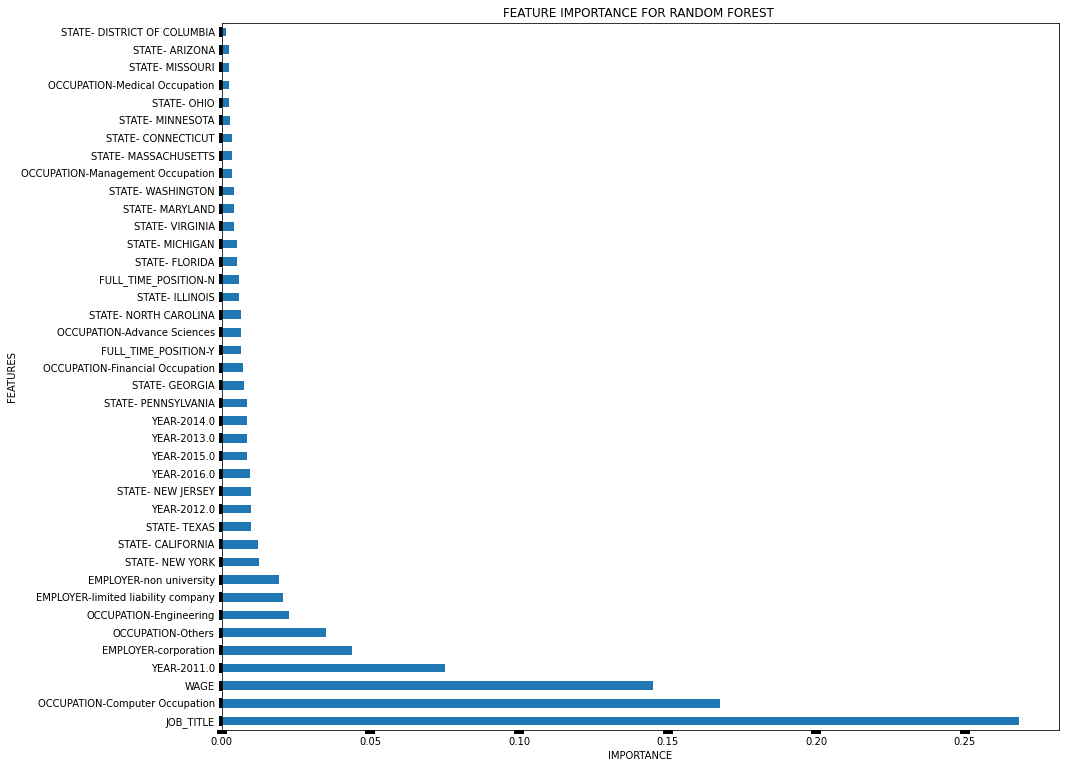

<Figure size 432x288 with 0 Axes>

In [0]:
# Plotting top 40 important features
fig,ax = plt.subplots(figsize=(15,13))
ax.tick_params(labelsize='medium', width=10)
importances = pd.Series(forest.feature_importances_, index=cols)
importances.nlargest(40).plot(kind='barh')
rf40 = pd.Series(forest.feature_importances_, index=cols).nlargest(40)
plt.title("FEATURE IMPORTANCE FOR RANDOM FOREST ")
plt.xlabel('IMPORTANCE')
plt.ylabel('FEATURES')
plt.show()
plt.savefig('/content/drive/My Drive/Colab Notebooks/H1B Case Status Prediction/Random Forest Feature Importance') 

In [0]:
rf40

JOB_TITLE                             0.268162
OCCUPATION-Computer Occupation        0.167530
WAGE                                  0.145206
YEAR-2011.0                           0.075003
EMPLOYER-corporation                  0.043673
OCCUPATION-Others                     0.034887
OCCUPATION-Engineering                0.022430
EMPLOYER-limited liability company    0.020519
EMPLOYER-non university               0.019083
STATE- NEW YORK                       0.012514
STATE- CALIFORNIA                     0.012177
STATE- TEXAS                          0.009975
YEAR-2012.0                           0.009869
STATE- NEW JERSEY                     0.009685
YEAR-2016.0                           0.009551
YEAR-2015.0                           0.008575
YEAR-2013.0                           0.008536
YEAR-2014.0                           0.008488
STATE- PENNSYLVANIA                   0.008379
STATE- GEORGIA                        0.007351
OCCUPATION-Financial Occupation       0.007213
FULL_TIME_POS

#XG-BOOST

In [0]:
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [0]:
xgb = XGBClassifier()
xgb.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [0]:
print(xgb)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


In [0]:
y_pred = xgb.predict(x_test)
predictions = [round(value) for value in y_pred]

In [0]:
accuracy = accuracy_score(y_test, predictions)
print("Accuracy for XGBoost on test set:", accuracy)

Accuracy for XGBoost on test set: 0.8969483107887343


In [0]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.92      0.87      0.89      7567
           1       0.88      0.92      0.90      7736

    accuracy                           0.90     15303
   macro avg       0.90      0.90      0.90     15303
weighted avg       0.90      0.90      0.90     15303



[[6579  988]
 [ 589 7147]]


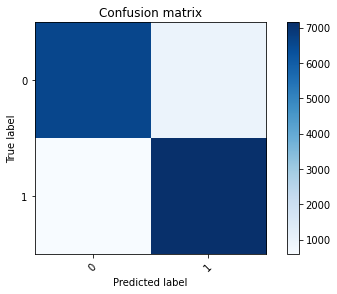

In [0]:
cm = confusion_matrix(y_test, y_pred)
print(cm)
plot_confusion_matrix(cm,['0','1'])

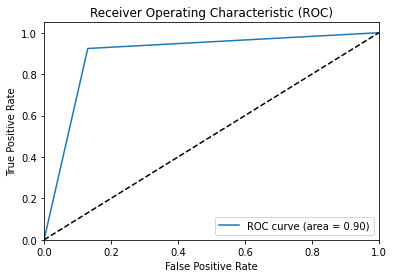

In [0]:
plot_roc(y_pred,y_test)

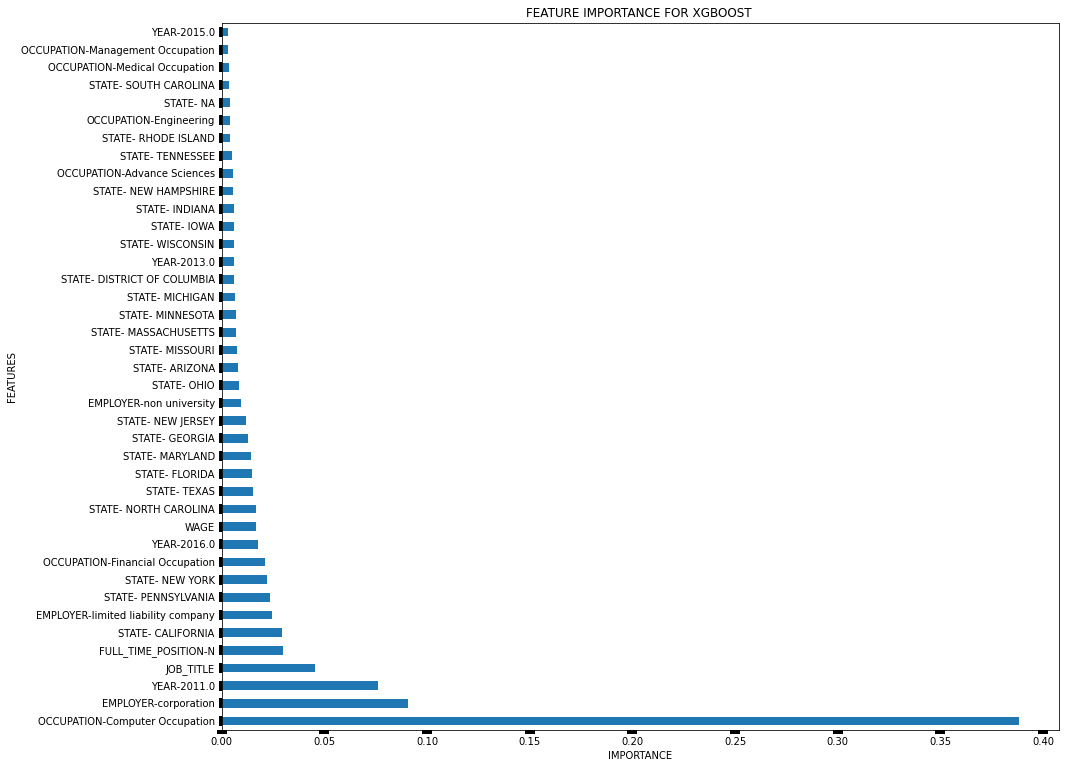

<Figure size 432x288 with 0 Axes>

In [0]:
# Plotting top 40 features
fig,ax = plt.subplots(figsize=(15,13))
ax.tick_params(labelsize='medium', width=10)
importances = pd.Series(xgb.feature_importances_, index=cols)
importances.nlargest(40).plot(kind='barh')
xgb40 = pd.Series(xgb.feature_importances_, index=cols).nlargest(40)
plt.title("FEATURE IMPORTANCE FOR XGBOOST ")
plt.xlabel('IMPORTANCE')
plt.ylabel('FEATURES')
plt.show()
plt.savefig('/content/drive/My Drive/Colab Notebooks/H1B Case Status Prediction/XGBoost Feature Importance') 

In [0]:
xgb40

OCCUPATION-Computer Occupation        0.388229
EMPLOYER-corporation                  0.090553
YEAR-2011.0                           0.075972
JOB_TITLE                             0.045291
FULL_TIME_POSITION-N                  0.029920
STATE- CALIFORNIA                     0.029080
EMPLOYER-limited liability company    0.024537
STATE- PENNSYLVANIA                   0.023438
STATE- NEW YORK                       0.021862
OCCUPATION-Financial Occupation       0.020877
YEAR-2016.0                           0.017707
WAGE                                  0.016683
STATE- NORTH CAROLINA                 0.016598
STATE- TEXAS                          0.015168
STATE- FLORIDA                        0.014550
STATE- MARYLAND                       0.014418
STATE- GEORGIA                        0.012809
STATE- NEW JERSEY                     0.011576
EMPLOYER-non university               0.009355
STATE- OHIO                           0.008512
STATE- ARIZONA                        0.008005
STATE- MISSOU

#Neural Networks

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
model = Sequential()
model.add(Dense(64, input_dim=x_train.shape[1], activation='tanh'))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=20, 
                        verbose=2, mode='min')

chckpt = ModelCheckpoint(filepath='.weights.hdf5', verbose=1, save_best_only=True)

model.fit(x_train,y_train,verbose=2,epochs=200, batch_size=20, 
          callbacks=[monitor, chckpt], validation_split=0.25)

Epoch 1/200

Epoch 00001: val_loss improved from inf to 0.29238, saving model to .weights.hdf5
2296/2296 - 4s - loss: 0.3205 - accuracy: 0.8733 - val_loss: 0.2924 - val_accuracy: 0.8838
Epoch 2/200

Epoch 00002: val_loss improved from 0.29238 to 0.26195, saving model to .weights.hdf5
2296/2296 - 4s - loss: 0.2671 - accuracy: 0.8988 - val_loss: 0.2619 - val_accuracy: 0.9051
Epoch 3/200

Epoch 00003: val_loss improved from 0.26195 to 0.25556, saving model to .weights.hdf5
2296/2296 - 4s - loss: 0.2451 - accuracy: 0.9095 - val_loss: 0.2556 - val_accuracy: 0.9068
Epoch 4/200

Epoch 00004: val_loss improved from 0.25556 to 0.24029, saving model to .weights.hdf5
2296/2296 - 4s - loss: 0.2302 - accuracy: 0.9178 - val_loss: 0.2403 - val_accuracy: 0.9123
Epoch 5/200

Epoch 00005: val_loss improved from 0.24029 to 0.22759, saving model to .weights.hdf5
2296/2296 - 4s - loss: 0.2200 - accuracy: 0.9220 - val_loss: 0.2276 - val_accuracy: 0.9200
Epoch 6/200

Epoch 00006: val_loss improved from 0.227

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                4928      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 7,041
Trainable params: 7,041
Non-trainable params: 0
_________________________________________________________________


In [0]:
y_pred = model.predict(x_test)
y_pred

array([[5.8290020e-08],
       [5.8189034e-04],
       [9.9806912e-06],
       ...,
       [9.3989480e-01],
       [9.3143296e-01],
       [8.8021439e-01]], dtype=float32)

In [0]:
#from the y_pred, we will only be considering the one's greater than 0.5
argmax = []
for val in y_pred:
    if val >= 0.5:
      argmax.append(1)
    else:
        argmax.append(0)
argmax[:10]

[0, 0, 0, 1, 0, 1, 0, 1, 0, 0]

In [0]:
accuracy = accuracy_score(y_test,argmax)
print("Accuracy for neural network on test set:", accuracy)

Accuracy for neural network on test set: 0.9470692021172319


In [0]:
print(classification_report(y_test,argmax))

              precision    recall  f1-score   support

           0       0.97      0.92      0.94      7567
           1       0.92      0.98      0.95      7736

    accuracy                           0.95     15303
   macro avg       0.95      0.95      0.95     15303
weighted avg       0.95      0.95      0.95     15303



[[6950  617]
 [ 193 7543]]


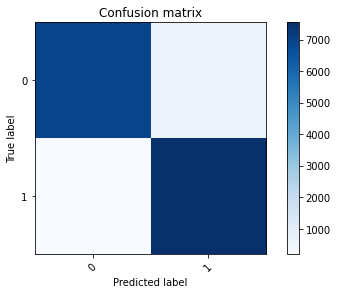

In [0]:
cm = confusion_matrix(y_test, argmax)
print(cm)
plot_confusion_matrix(cm,['0','1'])

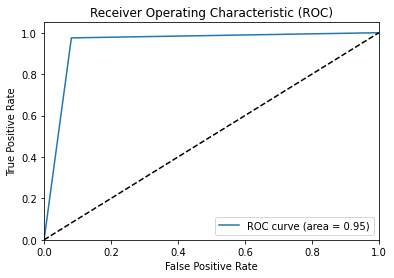

In [0]:
plot_roc(argmax,y_test)

#CNN

In [0]:
x_traincnn = np.expand_dims(x_train,axis=2)
x_testcnn = np.expand_dims(x_test, axis=2)

In [0]:
x_traincnn.shape

(61209, 76, 1)

In [0]:
x_testcnn.shape

(15303, 76, 1)

In [0]:
from sklearn import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, input_shape=(76,1), activation='relu'))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
#use_bias=True in dense layer
model.add(Dense(100, activation='relu', use_bias=True))
model.add(Dense(2, activation='softmax', use_bias=True))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(filepath=".best_weights.hdf5", verbose=0, save_best_only=True)
model.fit(x_traincnn, y_train,validation_data=(x_testcnn,y_test),callbacks=[monitor,checkpointer],verbose=2,epochs=200)
model.load_weights('.best_weights.hdf5')

model.summary()

Epoch 1/200
1913/1913 - 19s - loss: 0.3465 - accuracy: 0.8618 - val_loss: 0.2898 - val_accuracy: 0.8891
Epoch 2/200
1913/1913 - 19s - loss: 0.2926 - accuracy: 0.8884 - val_loss: 0.2636 - val_accuracy: 0.9016
Epoch 3/200
1913/1913 - 19s - loss: 0.2719 - accuracy: 0.8971 - val_loss: 0.2573 - val_accuracy: 0.9060
Epoch 4/200
1913/1913 - 19s - loss: 0.2588 - accuracy: 0.9045 - val_loss: 0.2429 - val_accuracy: 0.9134
Epoch 5/200
1913/1913 - 19s - loss: 0.2487 - accuracy: 0.9099 - val_loss: 0.2413 - val_accuracy: 0.9149
Epoch 6/200
1913/1913 - 19s - loss: 0.2430 - accuracy: 0.9132 - val_loss: 0.2344 - val_accuracy: 0.9169
Epoch 7/200
1913/1913 - 19s - loss: 0.2374 - accuracy: 0.9149 - val_loss: 0.2361 - val_accuracy: 0.9194
Epoch 8/200
1913/1913 - 19s - loss: 0.2352 - accuracy: 0.9163 - val_loss: 0.2296 - val_accuracy: 0.9183
Epoch 9/200
1913/1913 - 19s - loss: 0.2296 - accuracy: 0.9189 - val_loss: 0.2285 - val_accuracy: 0.9196
Epoch 10/200
1913/1913 - 19s - loss: 0.2277 - accuracy: 0.9190 -

In [0]:
y_pred = model.predict(x_testcnn)
y_pred

array([[9.9998343e-01, 1.6543976e-05],
       [9.8225164e-01, 1.7748289e-02],
       [9.9992228e-01, 7.7667602e-05],
       ...,
       [9.2779085e-02, 9.0722090e-01],
       [3.3985257e-02, 9.6601468e-01],
       [1.1184536e-01, 8.8815463e-01]], dtype=float32)

In [0]:
y_pred = y_pred.argmax(axis=1)

In [0]:
y_pred = y_pred.astype(int).flatten()

In [0]:
accuracy = accuracy_score(y_test,y_pred)
print("Accuracy of CNN on test set:", accuracy)

Accuracy of CNN on test set: 0.9353068025877279


In [0]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.96      0.91      0.93      7567
           1       0.91      0.96      0.94      7736

    accuracy                           0.94     15303
   macro avg       0.94      0.93      0.94     15303
weighted avg       0.94      0.94      0.94     15303



[[6950  617]
 [ 193 7543]]


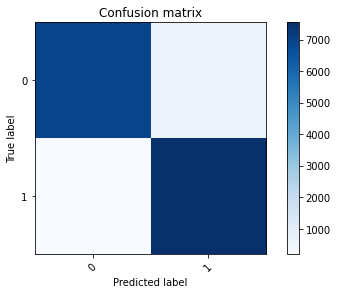

In [0]:
cm = confusion_matrix(y_test, argmax)
print(cm)
plot_confusion_matrix(cm,['0','1'])

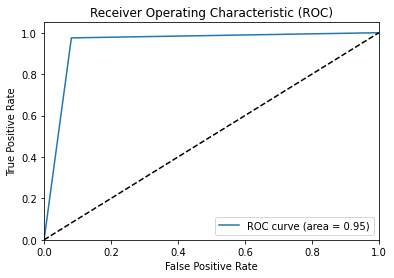

In [0]:
plot_roc(argmax,y_test)

# Selecting the best features from the Logistic Regression, L1 Logistic Regression, Random Forest and XGBOOST

In [0]:
# intersecting features of logistic regression and logistic regression L1
intersection1 = lr40.index.intersection(clf40.index)

In [0]:
# intersecting features of random forest and XGBoost
intersection2 = rf40.index.intersection(xgb40.index)

In [0]:
# Fetching all common Column names from top 40 features 
featurecolumns = intersection1.intersection(intersection2)

In [0]:
finalcols = featurecolumns.tolist()

In [0]:
finalcols

['OCCUPATION-Computer Occupation',
 'STATE- NEW YORK',
 'EMPLOYER-corporation',
 'YEAR-2016.0',
 'STATE- NEW JERSEY',
 'STATE- TEXAS',
 'STATE- PENNSYLVANIA',
 'STATE- GEORGIA',
 'YEAR-2015.0',
 'YEAR-2013.0',
 'FULL_TIME_POSITION-N',
 'EMPLOYER-non university',
 'OCCUPATION-Financial Occupation']

In [0]:
x_train = pd.DataFrame(x_train)
x_test = pd.DataFrame(x_test)

In [0]:
x_train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75
0,-0.573095,1.740717,-0.425196,0.425196,-0.350732,-0.388816,-0.408450,2.179059,-0.529244,-0.536319,1.014305,-0.36951,-0.768492,-0.126164,-0.162381,-0.05936,-1.466024,-0.352852,-0.186401,-0.162501,-0.081999,-0.122682,3.054512,-0.04862,-0.019251,-0.12355,-0.059746,2.262760,-0.106883,-0.142864,-0.08877,-0.083148,-0.180332,-0.194313,-0.030447,-0.038101,-0.246878,-0.094818,-0.070758,-0.064682,-0.058454,-0.04658,-0.033717,-0.136407,-0.205619,-0.179579,-0.142678,-0.025941,-0.109417,-0.013512,-0.017206,-0.051385,-0.047134,-0.059024,-0.302020,-0.034212,-0.307934,-0.179625,-0.021664,-0.174314,-0.046034,-0.092289,-0.204808,-0.014048,-0.068341,-0.060499,-0.017763,-0.094869,-0.332994,-0.061563,-0.023792,-0.187157,-0.1877,-0.022276,-0.108923,-0.011053
1,-0.626161,-0.793831,-0.425196,0.425196,-0.350732,-0.388816,2.448277,-0.458914,-0.529244,-0.536319,1.014305,-0.36951,-0.768492,-0.126164,-0.162381,-0.05936,0.682117,-0.352852,-0.186401,-0.162501,-0.081999,-0.122682,-0.327385,-0.04862,-0.019251,-0.12355,-0.059746,-0.441938,-0.106883,-0.142864,-0.08877,-0.083148,-0.180332,-0.194313,-0.030447,-0.038101,-0.246878,-0.094818,-0.070758,-0.064682,-0.058454,-0.04658,-0.033717,-0.136407,-0.205619,-0.179579,-0.142678,-0.025941,-0.109417,-0.013512,-0.017206,-0.051385,-0.047134,-0.059024,3.311034,-0.034212,-0.307934,-0.179625,-0.021664,-0.174314,-0.046034,-0.092289,-0.204808,-0.014048,-0.068341,-0.060499,-0.017763,-0.094869,-0.332994,-0.061563,-0.023792,-0.187157,-0.1877,-0.022276,-0.108923,-0.011053
2,-0.626161,-0.538402,-0.425196,0.425196,-0.350732,-0.388816,-0.408450,2.179059,-0.529244,-0.536319,1.014305,-0.36951,-0.768492,-0.126164,-0.162381,-0.05936,0.682117,-0.352852,-0.186401,-0.162501,-0.081999,-0.122682,-0.327385,-0.04862,-0.019251,-0.12355,-0.059746,-0.441938,-0.106883,-0.142864,-0.08877,-0.083148,-0.180332,-0.194313,-0.030447,-0.038101,4.050581,-0.094818,-0.070758,-0.064682,-0.058454,-0.04658,-0.033717,-0.136407,-0.205619,-0.179579,-0.142678,-0.025941,-0.109417,-0.013512,-0.017206,-0.051385,-0.047134,-0.059024,-0.302020,-0.034212,-0.307934,-0.179625,-0.021664,-0.174314,-0.046034,-0.092289,-0.204808,-0.014048,-0.068341,-0.060499,-0.017763,-0.094869,-0.332994,-0.061563,-0.023792,-0.187157,-0.1877,-0.022276,-0.108923,-0.011053
3,2.259157,1.504994,-0.425196,0.425196,-0.350732,-0.388816,-0.408450,2.179059,-0.529244,-0.536319,1.014305,-0.36951,-0.768492,-0.126164,-0.162381,-0.05936,-1.466024,-0.352852,5.364782,-0.162501,-0.081999,-0.122682,-0.327385,-0.04862,-0.019251,-0.12355,-0.059746,-0.441938,-0.106883,-0.142864,-0.08877,-0.083148,-0.180332,-0.194313,-0.030447,-0.038101,-0.246878,-0.094818,-0.070758,-0.064682,-0.058454,-0.04658,-0.033717,-0.136407,-0.205619,-0.179579,-0.142678,-0.025941,-0.109417,-0.013512,-0.017206,-0.051385,-0.047134,-0.059024,-0.302020,-0.034212,3.247446,-0.179625,-0.021664,-0.174314,-0.046034,-0.092289,-0.204808,-0.014048,-0.068341,-0.060499,-0.017763,-0.094869,-0.332994,-0.061563,-0.023792,-0.187157,-0.1877,-0.022276,-0.108923,-0.011053
4,-0.520877,0.913402,-0.425196,0.425196,2.851183,-0.388816,-0.408450,-0.458914,-0.529244,-0.536319,1.014305,-0.36951,-0.768492,-0.126164,-0.162381,-0.05936,-1.466024,2.834052,-0.186401,-0.162501,-0.081999,-0.122682,-0.327385,-0.04862,-0.019251,-0.12355,-0.059746,2.262760,-0.106883,-0.142864,-0.08877,-0.083148,-0.180332,-0.194313,-0.030447,-0.038101,-0.246878,-0.094818,-0.070758,-0.064682,-0.058454,-0.04658,-0.033717,-0.136407,-0.205619,-0.179579,-0.142678,-0.025941,-0.109417,-0.013512,-0.017206,-0.051385,-0.047134,-0.059024,-0.302020,-0.034212,-0.307934,-0.179625,-0.021664,-0.174314,-0.046034,-0.092289,-0.204808,-0.014048,-0.068341,-0.060499,-0.017763,-0.094869,-0.332994,-0.061563,-0.023792,-0.187157,-0.1877,-0.022276,-0.108923,-0.011053
...,...,...,...,...,...,...,...,...,...,

In [0]:
for i in range(x_train.shape[1]):
  x_train = x_train.rename(columns={i:cols[i]})

In [0]:
x_train

,JOB_TITLE,WAGE,FULL_TIME_POSITION-N,FULL_TIME_POSITION-Y,YEAR-2011.0,YEAR-2012.0,YEAR-2013.0,YEAR-2014.0,YEAR-2015.0,YEAR-2016.0,EMPLOYER-corporation,EMPLOYER-limited liability company,EMPLOYER-non university,EMPLOYER-university,OCCUPATION-Advance Sciences,OCCUPATION-Bussiness and Marketing Occupation,OCCUPATION-Computer Occupation,OCCUPATION-Engineering,OCCUPATION-Financial Occupation,OCCUPATION-Management Occupation,OCCUPATION-Mathematical Occupation,OCCUPATION-Medical Occupation,OCCUPATION-Others,STATE- ALABAMA,STATE- ALASKA,STATE- ARIZONA,STATE- ARKANSAS,STATE- CALIFORNIA,STATE- COLORADO,STATE- CONNECTICUT,STATE- DELAWARE,STATE- DISTRICT OF COLUMBIA,STATE- FLORIDA,STATE- GEORGIA,STATE- HAWAII,STATE- IDAHO,STATE- ILLINOIS,STATE- INDIANA,STATE- IOWA,STATE- KANSAS,STATE- KENTUCKY,STATE- LOUISIANA,STATE- MAINE,STATE- MARYLAND,STATE- MASSACHUSETTS,STATE- MICHIGAN,STATE- MINNESOTA,STATE- MISSISSIPPI,STATE- MISSOURI,STATE- MONTANA,STATE- NA,STATE- NEBRASKA,STATE- NEVADA,STATE- NEW HAMPSHIRE,STATE- NEW JERSEY,STATE- NEW MEXICO,STATE- NEW YORK,STATE- NORTH CAROLINA,STATE- NORTH DAKOTA,STATE- OHIO,STATE- OKLAHOMA,STATE- OREGON,STATE- PENNSYLVANIA,STATE- PUERTO RICO,STATE- RHODE ISLAND,STATE- SOUTH CAROLINA,STATE- SOUTH DAKOTA,STATE- TENNESSEE,STATE- TEXAS,STATE- UTAH,STATE- VERMONT,STATE- VIRGINIA,STATE- WASHINGTON,STATE- WEST VIRGINIA,STATE- WISCONSIN,STATE- WYOMING
0,-0.573095,1.740717,-0.425196,0.425196,-0.350732,-0.388816,-0.408450,2.179059,-0.529244,-0.536319,1.014305,-0.36951,-0.768492,-0.126164,-0.162381,-0.05936,-1.466024,-0.352852,-0.186401,-0.162501,-0.081999,-0.122682,3.054512,-0.04862,-0.019251,-0.12355,-0.059746,2.262760,-0.106883,-0.142864,-0.08877,-0.083148,-0.180332,-0.194313,-0.030447,-0.038101,-0.246878,-0.094818,-0.070758,-0.064682,-0.058454,-0.04658,-0.033717,-0.136407,-0.205619,-0.179579,-0.142678,-0.025941,-0.109417,-0.013512,-0.017206,-0.051385,-0.047134,-0.059024,-0.302020,-0.034212,-0.307934,-0.179625,-0.021664,-0.174314,-0.046034,-0.092289,-0.204808,-0.014048,-0.068341,-0.060499,-0.017763,-0.094869,-0.332994,-0.061563,-0.023792,-0.187157,-0.1877,-0.022276,-0.108923,-0.011053
1,-0.626161,-0.793831,-0.425196,0.425196,-0.350732,-0.388816,2.448277,-0.458914,-0.529244,-0.536319,1.014305,-0.36951,-0.768492,-0.126164,-0.162381,-0.05936,0.682117,-0.352852,-0.186401,-0.162501,-0.081999,-0.122682,-0.327385,-0.04862,-0.019251,-0.12355,-0.059746,-0.441938,-0.106883,-0.142864,-0.08877,-0.083148,-0.180332,-0.194313,-0.030447,-0.038101,-0.246878,-0.094818,-0.070758,-0.064682,-0.058454,-0.04658,-0.033717,-0.136407,-0.205619,-0.179579,-0.142678,-0.025941,-0.109417,-0.013512,-0.017206,-0.051385,-0.047134,-0.059024,3.311034,-0.034212,-0.307934,-0.179625,-0.021664,-0.174314,-0.046034,-0.092289,-0.204808,-0.014048,-0.068341,-0.060499,-0.017763,-0.094869,-0.332994,-0.061563,-0.023792,-0.187157,-0.1877,-0.022276,-0.108923,-0.011053
2,-0.626161,-0.538402,-0.425196,0.425196,-0.350732,-0.388816,-0.408450,2.179059,-0.529244,-0.536319,1.014305,-0.36951,-0.768492,-0.126164,-0.162381,-0.05936,0.682117,-0.352852,-0.186401,-0.162501,-0.081999,-0.122682,-0.327385,-0.04862,-0.019251,-0.12355,-0.059746,-0.441938,-0.106883,-0.142864,-0.08877,-0.083148,-0.180332,-0.194313,-0.030447,-0.038101,4.050581,-0.094818,-0.070758,-0.064682,-0.058454,-0.04658,-0.033717,-0.136407,-0.205619,-0.179579,-0.142678,-0.025941,-0.109417,-0.013512,-0.017206,-0.051385,-0.047134,-0.059024,-0.302020,-0.034212,-0.307934,-0.179625,-0.021664,-0.174314,-0.046034,-0.092289,-0.204808,-0.014048,-0.068341,-0.060499,-0.017763,-0.094869,-0.332994,-0.061563,-0.023792,-0.187157,-0.1877,-0.022276,-0.108923,-0.011053
3,2.259157,1.504994,-0.425196,0.425196,-0.350732,-0.388816,-0.408450,2.179059,-0.529244,-0.536319,1.014305,-0.36951,-0.768492,-0.126164,-0.162381,-0.05936,-1.466024,-0.352852,5.364782,-0.162501,-0.081999,-0.122682,-0.327385,-0.04862,-0.019251,-0.12355,-0.059746,-0.441938,-0.106883,-0.142864,-0.08877,-0.083148,-0.180332,-0.194313,-0.030447,-0.038101,-0.246878,-0.09481

In [0]:
for i in range(x_test.shape[1]):
  x_test = x_test.rename(columns={i:cols[i]})

In [0]:
x_test

,JOB_TITLE,WAGE,FULL_TIME_POSITION-N,FULL_TIME_POSITION-Y,YEAR-2011.0,YEAR-2012.0,YEAR-2013.0,YEAR-2014.0,YEAR-2015.0,YEAR-2016.0,EMPLOYER-corporation,EMPLOYER-limited liability company,EMPLOYER-non university,EMPLOYER-university,OCCUPATION-Advance Sciences,OCCUPATION-Bussiness and Marketing Occupation,OCCUPATION-Computer Occupation,OCCUPATION-Engineering,OCCUPATION-Financial Occupation,OCCUPATION-Management Occupation,OCCUPATION-Mathematical Occupation,OCCUPATION-Medical Occupation,OCCUPATION-Others,STATE- ALABAMA,STATE- ALASKA,STATE- ARIZONA,STATE- ARKANSAS,STATE- CALIFORNIA,STATE- COLORADO,STATE- CONNECTICUT,STATE- DELAWARE,STATE- DISTRICT OF COLUMBIA,STATE- FLORIDA,STATE- GEORGIA,STATE- HAWAII,STATE- IDAHO,STATE- ILLINOIS,STATE- INDIANA,STATE- IOWA,STATE- KANSAS,STATE- KENTUCKY,STATE- LOUISIANA,STATE- MAINE,STATE- MARYLAND,STATE- MASSACHUSETTS,STATE- MICHIGAN,STATE- MINNESOTA,STATE- MISSISSIPPI,STATE- MISSOURI,STATE- MONTANA,STATE- NA,STATE- NEBRASKA,STATE- NEVADA,STATE- NEW HAMPSHIRE,STATE- NEW JERSEY,STATE- NEW MEXICO,STATE- NEW YORK,STATE- NORTH CAROLINA,STATE- NORTH DAKOTA,STATE- OHIO,STATE- OKLAHOMA,STATE- OREGON,STATE- PENNSYLVANIA,STATE- PUERTO RICO,STATE- RHODE ISLAND,STATE- SOUTH CAROLINA,STATE- SOUTH DAKOTA,STATE- TENNESSEE,STATE- TEXAS,STATE- UTAH,STATE- VERMONT,STATE- VIRGINIA,STATE- WASHINGTON,STATE- WEST VIRGINIA,STATE- WISCONSIN,STATE- WYOMING
0,-0.079339,-0.144500,-0.425196,0.425196,2.851183,-0.388816,-0.40845,-0.458914,-0.529244,-0.536319,1.014305,-0.369510,-0.768492,-0.126164,-0.162381,-0.05936,0.682117,-0.352852,-0.186401,-0.162501,-0.081999,-0.122682,-0.327385,-0.04862,-0.019251,-0.12355,-0.059746,-0.441938,-0.106883,-0.142864,-0.08877,-0.083148,5.545325,-0.194313,-0.030447,-0.038101,-0.246878,-0.094818,-0.070758,-0.064682,-0.058454,-0.04658,-0.033717,-0.136407,-0.205619,-0.179579,-0.142678,-0.025941,-0.109417,-0.013512,-0.017206,-0.051385,-0.047134,-0.059024,-0.302020,-0.034212,-0.307934,-0.179625,-0.021664,-0.174314,-0.046034,-0.092289,-0.204808,-0.014048,-0.068341,-0.060499,-0.017763,-0.094869,-0.332994,-0.061563,-0.023792,-0.187157,-0.1877,-0.022276,-0.108923,-0.011053
1,-0.383297,0.350582,-0.425196,0.425196,-0.350732,-0.388816,-0.40845,-0.458914,-0.529244,1.864563,-0.985897,-0.369510,1.301250,-0.126164,-0.162381,-0.05936,0.682117,-0.352852,-0.186401,-0.162501,-0.081999,-0.122682,-0.327385,-0.04862,-0.019251,-0.12355,-0.059746,2.262760,-0.106883,-0.142864,-0.08877,-0.083148,-0.180332,-0.194313,-0.030447,-0.038101,-0.246878,-0.094818,-0.070758,-0.064682,-0.058454,-0.04658,-0.033717,-0.136407,-0.205619,-0.179579,-0.142678,-0.025941,-0.109417,-0.013512,-0.017206,-0.051385,-0.047134,-0.059024,-0.302020,-0.034212,-0.307934,-0.179625,-0.021664,-0.174314,-0.046034,-0.092289,-0.204808,-0.014048,-0.068341,-0.060499,-0.017763,-0.094869,-0.332994,-0.061563,-0.023792,-0.187157,-0.1877,-0.022276,-0.108923,-0.011053
2,-0.366615,-0.000334,-0.425196,0.425196,2.851183,-0.388816,-0.40845,-0.458914,-0.529244,-0.536319,1.014305,-0.369510,-0.768492,-0.126164,-0.162381,-0.05936,-1.466024,2.834052,-0.186401,-0.162501,-0.081999,-0.122682,-0.327385,-0.04862,-0.019251,-0.12355,-0.059746,-0.441938,-0.106883,-0.142864,-0.08877,-0.083148,-0.180332,-0.194313,-0.030447,-0.038101,-0.246878,-0.094818,14.132769,-0.064682,-0.058454,-0.04658,-0.033717,-0.136407,-0.205619,-0.179579,-0.142678,-0.025941,-0.109417,-0.013512,-0.017206,-0.051385,-0.047134,-0.059024,-0.302020,-0.034212,-0.307934,-0.179625,-0.021664,-0.174314,-0.046034,-0.092289,-0.204808,-0.014048,-0.068341,-0.060499,-0.017763,-0.094869,-0.332994,-0.061563,-0.023792,-0.187157,-0.1877,-0.022276,-0.108923,-0.011053
3,-0.626161,-1.622700,-0.425196,0.425196,-0.350732,2.571911,-0.40845,-0.458914,-0.529244,-0.536319,1.014305,-0.369510,-0.768492,-0.126164,-0.162381,-0.05936,0.682117,-0.352852,-0.186401,-0.162501,-0.081999,-0.122682,-0.327385,-0.04862,-0.019251,-0.12355,-0.059746,-0.441938,-0.106883,-0.142864,-0.08877,-0.083148,-0.180332,5.146331,-0.030447,-0.038101,-0.246878,-0.094

In [0]:
def keep_cols(DataFrame, keep_these):
    """Keep only the columns [keep_these] in a DataFrame, delete
    all other columns. 
    """
    drop_these = list(set(list(DataFrame)) - set(keep_these))
    return DataFrame.drop(drop_these, axis = 1)

In [0]:
X_train = keep_cols(x_train,finalcols)

In [0]:
X_test = keep_cols(x_test,finalcols)

In [0]:
print(X_train.shape)
print(X_test.shape)

(61209, 13)
(15303, 13)


In [0]:
X_train

,FULL_TIME_POSITION-N,YEAR-2013.0,YEAR-2015.0,YEAR-2016.0,EMPLOYER-corporation,EMPLOYER-non university,OCCUPATION-Computer Occupation,OCCUPATION-Financial Occupation,STATE- GEORGIA,STATE- NEW JERSEY,STATE- NEW YORK,STATE- PENNSYLVANIA,STATE- TEXAS
0,-0.425196,-0.408450,-0.529244,-0.536319,1.014305,-0.768492,-1.466024,-0.186401,-0.194313,-0.302020,-0.307934,-0.204808,-0.332994
1,-0.425196,2.448277,-0.529244,-0.536319,1.014305,-0.768492,0.682117,-0.186401,-0.194313,3.311034,-0.307934,-0.204808,-0.332994
2,-0.425196,-0.408450,-0.529244,-0.536319,1.014305,-0.768492,0.682117,-0.186401,-0.194313,-0.302020,-0.307934,-0.204808,-0.332994
3,-0.425196,-0.408450,-0.529244,-0.536319,1.014305,-0.768492,-1.466024,5.364782,-0.194313,-0.302020,3.247446,-0.204808,-0.332994
4,-0.425196,-0.408450,-0.529244,-0.536319,1.014305,-0.768492,-1.466024,-0.186401,-0.194313,-0.302020,-0.307934,-0.204808,-0.332994
...,...,...,...,...,...,...,...,...,...,...,...,...,...
61204,-0.425196,-0.408450,-0.529244,-0.536319,1.014305,-0.768492,-1.466024,-0.186401,-0.194313,-0.302020,-0.307934,-0.204808,3.003054
61205,2.351859,-0.408450,-0.529244,1.864563,1.014305,-0.768492,0.682117,-0.186401,-0.194313,3.311034,-0.307934,-0.204808,-0.332994
61206,2.351859,-0.408450,-0.529244,1.864563,1.014305,-0.768492,0.682117,-0.186401,-0.194313,3.311034,-0.307934,-0.204808,-0.332994
61207,-0.425196,-0.408450,-0.529244,1.864563,1.014305,-0.768492,0.682117,-0.186401,5.146331,-0.302020,-0.307934,-0.204808,-0.332994


In [0]:
X_test

,FULL_TIME_POSITION-N,YEAR-2013.0,YEAR-2015.0,YEAR-2016.0,EMPLOYER-corporation,EMPLOYER-non university,OCCUPATION-Computer Occupation,OCCUPATION-Financial Occupation,STATE- GEORGIA,STATE- NEW JERSEY,STATE- NEW YORK,STATE- PENNSYLVANIA,STATE- TEXAS
0,-0.425196,-0.40845,-0.529244,-0.536319,1.014305,-0.768492,0.682117,-0.186401,-0.194313,-0.302020,-0.307934,-0.204808,-0.332994
1,-0.425196,-0.40845,-0.529244,1.864563,-0.985897,1.301250,0.682117,-0.186401,-0.194313,-0.302020,-0.307934,-0.204808,-0.332994
2,-0.425196,-0.40845,-0.529244,-0.536319,1.014305,-0.768492,-1.466024,-0.186401,-0.194313,-0.302020,-0.307934,-0.204808,-0.332994
3,-0.425196,-0.40845,-0.529244,-0.536319,1.014305,-0.768492,0.682117,-0.186401,5.146331,-0.302020,-0.307934,-0.204808,-0.332994
4,-0.425196,-0.40845,-0.529244,-0.536319,-0.985897,-0.768492,-1.466024,-0.186401,-0.194313,-0.302020,3.247446,-0.204808,-0.332994
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15298,-0.425196,-0.40845,-0.529244,-0.536319,1.014305,-0.768492,-1.466024,-0.186401,-0.194313,-0.302020,-0.307934,-0.204808,-0.332994
15299,-0.425196,-0.40845,-0.529244,-0.536319,1.014305,-0.768492,0.682117,-0.186401,-0.194313,-0.302020,3.247446,-0.204808,-0.332994
15300,-0.425196,-0.40845,-0.529244,-0.536319,1.014305,-0.768492,0.682117,-0.186401,-0.194313,3.311034,-0.307934,-0.204808,-0.332994
15301,-0.425196,-0.40845,1.889488,-0.536319,-0.985897,1.301250,0.682117,-0.186401,-0.194313,-0.302020,-0.307934,4.882630,-0.332994


#Neural Networks with Top features

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='tanh'))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=20, 
                        verbose=2, mode='min')

chckpt = ModelCheckpoint(filepath='.weights.hdf5', verbose=1, save_best_only=True)

model.fit(X_train,y_train,verbose=2,epochs=200, batch_size=20, 
          callbacks=[monitor, chckpt], validation_split=0.25)

Epoch 1/200

Epoch 00001: val_loss improved from inf to 0.42246, saving model to .weights.hdf5
2296/2296 - 4s - loss: 0.4322 - accuracy: 0.8136 - val_loss: 0.4225 - val_accuracy: 0.8197
Epoch 2/200

Epoch 00002: val_loss improved from 0.42246 to 0.41442, saving model to .weights.hdf5
2296/2296 - 3s - loss: 0.4146 - accuracy: 0.8217 - val_loss: 0.4144 - val_accuracy: 0.8218
Epoch 3/200

Epoch 00003: val_loss improved from 0.41442 to 0.41358, saving model to .weights.hdf5
2296/2296 - 3s - loss: 0.4089 - accuracy: 0.8239 - val_loss: 0.4136 - val_accuracy: 0.8211
Epoch 4/200

Epoch 00004: val_loss improved from 0.41358 to 0.41177, saving model to .weights.hdf5
2296/2296 - 3s - loss: 0.4063 - accuracy: 0.8250 - val_loss: 0.4118 - val_accuracy: 0.8219
Epoch 5/200

Epoch 00005: val_loss improved from 0.41177 to 0.40851, saving model to .weights.hdf5
2296/2296 - 3s - loss: 0.4036 - accuracy: 0.8256 - val_loss: 0.4085 - val_accuracy: 0.8247
Epoch 6/200

Epoch 00006: val_loss improved from 0.408

In [0]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 64)                896       
_________________________________________________________________
dense_6 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
Total params: 3,009
Trainable params: 3,009
Non-trainable params: 0
_________________________________________________________________


In [0]:
y_pred = model.predict(X_test)
y_pred

array([[0.70146745],
       [0.1312697 ],
       [0.07320234],
       ...,
       [0.88228947],
       [0.91770035],
       [0.6873221 ]], dtype=float32)

In [0]:
#from the y_pred, we will only be considering the one's greater than 0.5
argmax = []
for val in y_pred:
    if val >= 0.5:
      argmax.append(1)
    else:
        argmax.append(0)
argmax[:10]

[1, 0, 0, 1, 0, 1, 1, 1, 0, 0]

In [0]:
accuracy = accuracy_score(y_test,argmax)
print("Accuracy for neural networks:", accuracy )

Accuracy for neural networks: 0.8300333267986669


In [0]:
print(classification_report(y_test,argmax))

              precision    recall  f1-score   support

           0       0.90      0.74      0.81      7567
           1       0.78      0.92      0.85      7736

    accuracy                           0.83     15303
   macro avg       0.84      0.83      0.83     15303
weighted avg       0.84      0.83      0.83     15303



[[5612 1955]
 [ 646 7090]]


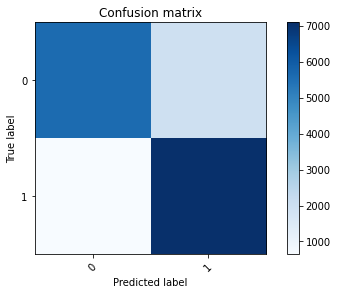

In [0]:
cm = confusion_matrix(y_test, argmax)
print(cm)
plot_confusion_matrix(cm,['0','1'])

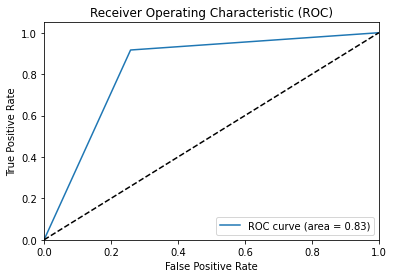

In [0]:
plot_roc(argmax,y_test)

#CNN with Top Features

In [0]:
X_traincnn = np.expand_dims(X_train,axis=2)
X_testcnn = np.expand_dims(X_test, axis=2)

In [0]:
X_traincnn.shape

(61209, 13, 1)

In [0]:
x_testcnn.shape

(15303, 76, 1)

In [0]:
from sklearn import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, input_shape=(13,1), activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Flatten())
#use_bias=True in dense layer
model.add(Dense(100, activation='relu', use_bias=True))
model.add(Dense(2, activation='softmax', use_bias=True))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(filepath=".best_weights.hdf5", verbose=0, save_best_only=True)
model.fit(X_traincnn, y_train,validation_data=(X_testcnn,y_test),callbacks=[monitor,checkpointer],verbose=2,epochs=200)
model.load_weights('.best_weights.hdf5')

model.summary()

Epoch 1/200
1913/1913 - 5s - loss: 0.4521 - accuracy: 0.8016 - val_loss: 0.4293 - val_accuracy: 0.8153
Epoch 2/200
1913/1913 - 5s - loss: 0.4370 - accuracy: 0.8116 - val_loss: 0.4270 - val_accuracy: 0.8195
Epoch 3/200
1913/1913 - 5s - loss: 0.4306 - accuracy: 0.8155 - val_loss: 0.4167 - val_accuracy: 0.8231
Epoch 4/200
1913/1913 - 5s - loss: 0.4259 - accuracy: 0.8180 - val_loss: 0.4128 - val_accuracy: 0.8226
Epoch 5/200
1913/1913 - 5s - loss: 0.4235 - accuracy: 0.8186 - val_loss: 0.4151 - val_accuracy: 0.8237
Epoch 6/200
1913/1913 - 5s - loss: 0.4203 - accuracy: 0.8200 - val_loss: 0.4117 - val_accuracy: 0.8250
Epoch 7/200
1913/1913 - 5s - loss: 0.4188 - accuracy: 0.8211 - val_loss: 0.4091 - val_accuracy: 0.8264
Epoch 8/200
1913/1913 - 5s - loss: 0.4172 - accuracy: 0.8222 - val_loss: 0.4070 - val_accuracy: 0.8257
Epoch 9/200
1913/1913 - 5s - loss: 0.4166 - accuracy: 0.8223 - val_loss: 0.4087 - val_accuracy: 0.8260
Epoch 10/200
1913/1913 - 5s - loss: 0.4157 - accuracy: 0.8227 - val_loss:

In [0]:
y_pred = model.predict(X_testcnn)
y_pred

array([[0.3171838 , 0.6828162 ],
       [0.834689  , 0.16531092],
       [0.93839157, 0.06160846],
       ...,
       [0.11471637, 0.88528365],
       [0.09188094, 0.908119  ],
       [0.29021963, 0.70978034]], dtype=float32)

In [0]:
y_pred = y_pred.argmax(axis=1)

In [0]:
y_pred = y_pred.astype(int).flatten()

In [0]:
accuracy = accuracy_score(y_test,y_pred)
print("Accuracy for CNN:" ,accuracy)

Accuracy for CNN: 0.8273541135725021


In [0]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.90      0.74      0.81      7567
           1       0.78      0.92      0.84      7736

    accuracy                           0.83     15303
   macro avg       0.84      0.83      0.83     15303
weighted avg       0.84      0.83      0.83     15303



[[5612 1955]
 [ 646 7090]]


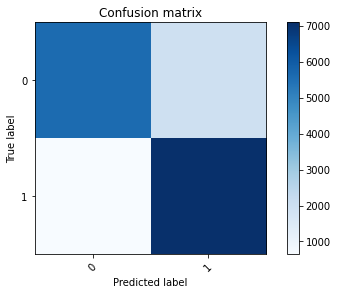

In [0]:
cm = confusion_matrix(y_test, argmax)
print(cm)
plot_confusion_matrix(cm,['0','1'])

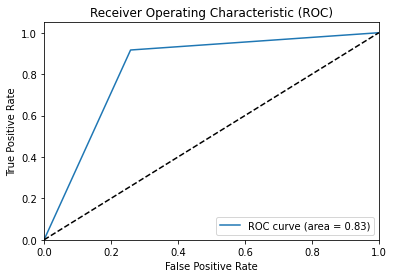

In [0]:
plot_roc(argmax,y_test)